## add to path

In [2]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems\search\notebooks
Parent Directory: D:\mukul\Desktop\Unimelb\Masters\Capstone\Learning-Dynamic-Systems


# Smart search algorithm testing
Idea: Coarse search inside the region, fine search on the edges

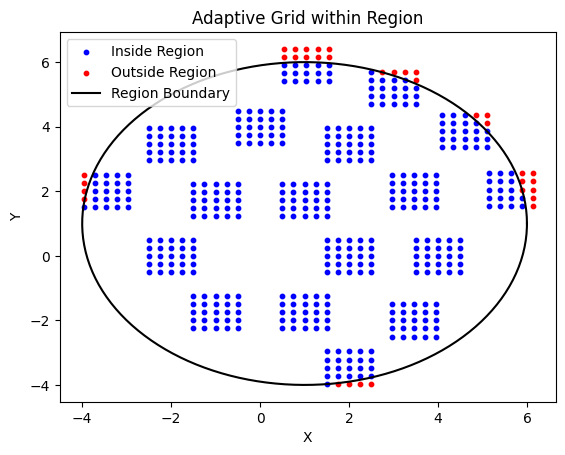

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class AdaptiveGrid:
    def __init__(self, center, region_extent, coarse_resolution=10, fine_resolution=20, tolerance=0.1, is_point_in_region_func=None):
        """
        center: The center of the region.
        region_extent: The extent of the region, half the width/height of the bounding box.
        coarse_resolution: Resolution of the coarse grid.
        fine_resolution: Resolution for refinement near the boundary.
        tolerance: The distance within which to refine the grid near the boundary.
        is_point_in_region_func: Black-box function that checks if a point is inside the region.
        """
        self.center = np.array(center)
        self.extent = np.array(region_extent)
        self.coarse_resolution = coarse_resolution
        self.fine_resolution = fine_resolution
        self.tolerance = tolerance
        self.is_point_in_region_func = is_point_in_region_func  # Accept the black-box function
    
    def generate_radial_grid(self, radius, num_points):
        """
        Generate grid points along the circumference of a circle of a given radius.
        """
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)  # Points on the circle
        points = np.array([self.center + radius * np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
        return points
    
    def refine_grid(self, grid):
        """
        Refine the grid near the boundary by increasing the resolution.
        """
        refined_grid = []
        for point in grid:
            if self.is_point_in_region_func(point):  # If the point is inside the region, check proximity to the boundary
                if self.is_near_boundary(point):
                    refined_grid.extend(self.refine_point(point))
                else:
                    refined_grid.append(point)
        return np.array(refined_grid)

    def is_near_boundary(self, point):
        """
        Check if a point is near the boundary (within tolerance).
        """
        distance_to_boundary = np.min(np.abs(point - self.center) - self.extent)
        return distance_to_boundary < self.tolerance
    
    def refine_point(self, point):
        """
        Refine the grid around the given point by creating a finer grid.
        """
        # Define the neighborhood to refine
        refined_points = []
        for dim in range(len(self.center)):
            new_points = np.linspace(point[dim] - self.tolerance, point[dim] + self.tolerance, self.fine_resolution)
            refined_points.append(new_points)
        
        refined_grid = np.array(np.meshgrid(*refined_points)).T.reshape(-1, len(self.center))
        return refined_grid
    
    def create_grid(self):
        """
        Create the entire adaptive grid using radial expansion from the center.
        """
        grid = []
        radius = self.coarse_resolution  # Start with a coarse resolution at the center
        while radius < np.max(self.extent):  # Expand until the region is fully covered
            num_points = int(2 * np.pi * radius / self.coarse_resolution)  # Number of points on the circle
            circle_grid = self.generate_radial_grid(radius, num_points)
            
            refined_grid = self.refine_grid(circle_grid)
            grid.extend(refined_grid)  # Add refined points to the grid
            
            radius += self.coarse_resolution  # Expand the radius for the next circle
        
        return np.array(grid)

# Plotting Function for the Grid
def plot_grid(grid, center, extent, boundary_func=None):
    """
    Plots the adaptive grid and region boundary.
    
    grid: The grid of points to plot.
    center: The center of the region.
    extent: The extents (half-width/height) of the region.
    boundary_func: A function that draws the boundary (if applicable).
    """
    fig, ax = plt.subplots()
    
    # Plot all grid points
    grid_inside = [point for point in grid if boundary_func(point)]  # Points inside the region
    grid_outside = [point for point in grid if not boundary_func(point)]  # Points outside the region

    grid_inside = np.array(grid_inside)
    grid_outside = np.array(grid_outside)

    # Plot inside region points in blue and outside in red
    ax.scatter(grid_inside[:, 0], grid_inside[:, 1], c='blue', label='Inside Region', s=10)
    ax.scatter(grid_outside[:, 0], grid_outside[:, 1], c='red', label='Outside Region', s=10)

    # Plot boundary (for circle, just plot the circumference)
    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + extent[0] * np.cos(theta)
    y_boundary = center[1] + extent[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, color='black', label='Region Boundary')

    # Labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Adaptive Grid within Region')
    ax.legend()
    plt.show()

actual_center = [1,1]
actual_radius = [5,5]
# Sample Black-box Function for Testing (circle region with approximate center)
def sample_is_point_in_region(point, center=actual_center):
    """
    A simple black-box function that checks if a point is inside a circular region.
    For this example, we use a circle centered at [1,1] with radius 5.
    The center is an approximation.
    """
    # Here we treat the center with a small tolerance region
    center = actual_center 
    radius = 5
    distance = np.linalg.norm(center - point)
    return distance <= radius

# Example usage:
center = [0, 0]  # 2D region center (approximate)
region_extent = [10, 10]  # Half-extents of the region
coarse_resolution = 2  # Coarse grid resolution
fine_resolution = 5  # Fine grid resolution near the boundary
tolerance = 0.5  # Distance from the boundary to refine

# Create the AdaptiveGrid instance, passing in the black-box function
adaptive_grid = AdaptiveGrid(center, region_extent, coarse_resolution, fine_resolution, tolerance, sample_is_point_in_region)

# Create the grid
grid = adaptive_grid.create_grid()


# Plot the grid along with the boundary
plot_grid(grid, actual_center, actual_radius, boundary_func=sample_is_point_in_region)


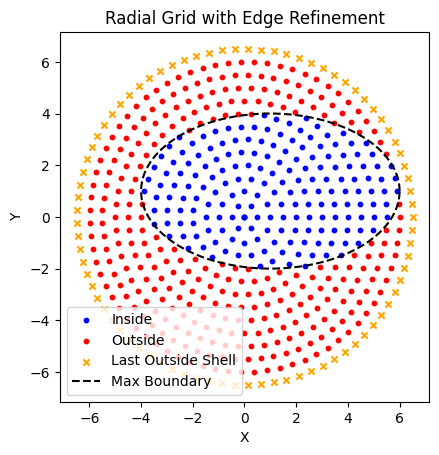

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_sizes, point_spacing, angular_resolution=36, refinement_factor=2, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_sizes = np.array(initial_step_sizes)
        self.point_spacing = point_spacing  # Desired distance between points on circumference
        self.angular_resolution = angular_resolution
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        points_inside = []
        points_outside = []
        current_radii = np.zeros_like(self.center, dtype=float)
        step_sizes = self.initial_step_sizes.copy()

        finished = False
        last_inside_points = []
        last_outside_points = []  # To capture the first outside shell
        last_radii = None
        hit_empty_layer = False
        step_decrease_factor = 1

        while not finished:
            shell_points_inside = []
            shell_points_outside = []
            any_point_inside = False

            # Calculate the number of points based on current radius
            radius = current_radii[0]  # Assuming circular symmetry, use the first element
            circumference = 2 * np.pi * radius
            num_points = max(int(circumference / self.point_spacing), 3)  # At least 3 points for stability
            angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
            
            for angle in angles:
                x = self.center[0] + radius * np.cos(angle)
                y = self.center[1] + radius * np.sin(angle)
                point = np.array([x, y])

                if self.is_point_in_region_func(point):
                    shell_points_inside.append(point)
                    any_point_inside = True
                else:
                    shell_points_outside.append(point)

            if any_point_inside:
                points_inside.extend(shell_points_inside)
                last_inside_points = shell_points_inside
                last_radii = current_radii.copy()
            else:
                # First shell that's entirely outside
                if not hit_empty_layer and last_inside_points:
                    hit_empty_layer = True
                    last_outside_points = shell_points_outside  # Capture the outside shell

                    # Start refining
                    refined_radii = last_radii.copy()
                    refined_step = step_sizes / self.refinement_factor

                    # Decrease the spacing gradually while refining the edge
                    for i in range(1, self.refinement_factor + 1):
                        refined_radius = refined_radii + i * refined_step
                        for angle in angles:
                            x = self.center[0] + refined_radius[0] * np.cos(angle)
                            y = self.center[1] + refined_radius[1] * np.sin(angle)
                            point = np.array([x, y])
                            if self.is_point_in_region_func(point):
                                points_inside.append(point)

                    # Once refined, stop expanding and adjust for finer details back inward
                    step_sizes = step_sizes / self.refinement_factor
                    break  # Stop after refinement to refine inward

            points_outside.extend(shell_points_outside)
            current_radii += step_sizes
            finished = np.any(current_radii > self.max_radius)

        return np.array(points_inside), np.array(points_outside), np.array(last_outside_points)

# Plotting Function
def plot_radial_grid(points_inside, points_outside, last_outside_points, center, max_radius, boundary_func=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if last_outside_points.size > 0:
        ax.scatter(last_outside_points[:, 0], last_outside_points[:, 1], c='orange', label='Last Outside Shell', s=20, marker='x')

    # Plot boundary (approximated ellipse)
    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Radial Grid with Edge Refinement")
    ax.legend()
    plt.show()

# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_sizes=[0.5, 0.5],
    point_spacing=0.5,  # Distance between consecutive points on the circumference
    angular_resolution=10,
    refinement_factor=2,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, last_outside_points = grid_gen.generate_grid()
plot_radial_grid(points_inside, points_outside, last_outside_points, actual_center, max_radius=ellipsoid_radii, boundary_func=is_inside_region)


no need to search in directions we already have detected an edge.

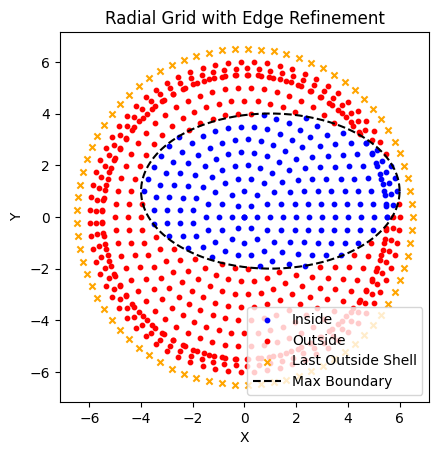

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_sizes, point_spacing, refinement_factor=2, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_sizes = np.array(initial_step_sizes)
        self.point_spacing = point_spacing  # Desired distance between points on circumference
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        points_inside = []
        points_outside = []
        current_radii = np.zeros_like(self.center, dtype=float)
        step_sizes = self.initial_step_sizes.copy()

        finished = False
        last_inside_points = []
        last_outside_points = []  # To capture the first outside shell
        last_radii = None
        hit_empty_layer = False
        step_decrease_factor = 1

        while not finished:
            shell_points_inside = []
            shell_points_outside = []
            any_point_inside = False

            # Calculate the number of points based on current radius
            radius = current_radii[0]  # Assuming circular symmetry, use the first element
            circumference = 2 * np.pi * radius
            num_points = max(int(circumference / self.point_spacing), 3)  # At least 3 points for stability
            angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
            
            for angle in angles:
                x = self.center[0] + radius * np.cos(angle)
                y = self.center[1] + radius * np.sin(angle)
                point = np.array([x, y])

                if self.is_point_in_region_func(point):
                    shell_points_inside.append(point)
                    any_point_inside = True
                else:
                    shell_points_outside.append(point)

            if any_point_inside:
                points_inside.extend(shell_points_inside)
                last_inside_points = shell_points_inside
                last_radii = current_radii.copy()
            else:
                # First shell that's entirely outside
                if not hit_empty_layer and last_inside_points:
                    hit_empty_layer = True
                    last_outside_points = shell_points_outside  # Capture the outside shell

                    # Start refining
                    refined_radii = last_radii.copy()
                    refined_step = step_sizes / self.refinement_factor

                    # Decrease the spacing gradually while refining the edge
                    for i in range(1, self.refinement_factor + 1):
                        refined_radius = refined_radii - i * refined_step
                        for angle in angles:
                            x = self.center[0] + refined_radius[0] * np.cos(angle)
                            y = self.center[1] + refined_radius[1] * np.sin(angle)
                            point = np.array([x, y])
                            if self.is_point_in_region_func(point):
                                points_inside.append(point)
                            else:
                                points_outside.append(point)

                    # Once refined, stop expanding and adjust for finer details back inward
                    step_sizes = step_sizes / self.refinement_factor
                    break  # Stop after refinement to refine inward

            points_outside.extend(shell_points_outside)
            current_radii += step_sizes
            finished = np.any(current_radii > self.max_radius)

        return np.array(points_inside), np.array(points_outside), np.array(last_outside_points)

# Plotting Function
def plot_radial_grid(points_inside, points_outside, last_outside_points, center, max_radius, boundary_func=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if last_outside_points.size > 0:
        ax.scatter(last_outside_points[:, 0], last_outside_points[:, 1], c='orange', label='Last Outside Shell', s=20, marker='x')

    # Plot boundary (approximated ellipse)
    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Radial Grid with Edge Refinement")
    ax.legend()
    plt.show()

# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_sizes=[0.5, 0.5],
    point_spacing=0.5,  # Distance between consecutive points on the circumference
    refinement_factor=2,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, last_outside_points = grid_gen.generate_grid()
plot_radial_grid(points_inside, points_outside, last_outside_points, actual_center, max_radius=ellipsoid_radii, boundary_func=is_inside_region)


detect the boundary

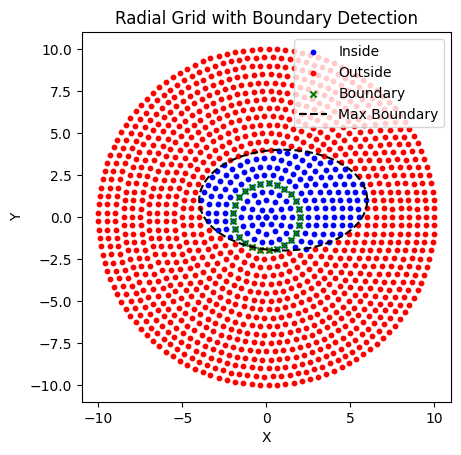

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_sizes, point_spacing, angular_resolution=36, refinement_factor=2, is_point_in_region_func=None, boundary_tolerance=0.1):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_sizes = np.array(initial_step_sizes)
        self.point_spacing = point_spacing  # Desired distance between points on circumference
        self.angular_resolution = angular_resolution
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func
        self.boundary_tolerance = boundary_tolerance  # Tolerance for detecting the boundary

    def generate_grid(self):
        points_inside = []
        points_outside = []
        boundary_points = []  # Points on the boundary
        current_radii = np.zeros_like(self.center, dtype=float)
        step_sizes = self.initial_step_sizes.copy()

        finished = False
        last_inside_points = []
        last_outside_points = []  # To capture the first outside shell
        last_radii = None
        hit_boundary = False

        while not finished:
            shell_points_inside = []
            shell_points_outside = []
            any_point_inside = False
            any_point_outside = False

            # Calculate the number of points based on current radius
            radius = current_radii[0]  # Assuming circular symmetry, use the first element
            circumference = 2 * np.pi * radius
            num_points = max(int(circumference / self.point_spacing), 3)  # At least 3 points for stability
            angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
            
            for angle in angles:
                x = self.center[0] + radius * np.cos(angle)
                y = self.center[1] + radius * np.sin(angle)
                point = np.array([x, y])

                if self.is_point_in_region_func(point):
                    shell_points_inside.append(point)
                    any_point_inside = True
                else:
                    shell_points_outside.append(point)
                    any_point_outside = True

            # If we detect a mixed shell with inside and outside points, we consider it as the boundary
            if any_point_inside and any_point_outside and not hit_boundary:
                hit_boundary = True
                # Add the points that are near the boundary
                boundary_points.extend(shell_points_inside)  # Add the inside points near boundary
                boundary_points.extend(shell_points_outside)  # Add the outside points near boundary

            # Add points to the respective inside and outside lists
            if any_point_inside:
                points_inside.extend(shell_points_inside)
                last_inside_points = shell_points_inside
            if any_point_outside:
                points_outside.extend(shell_points_outside)
                last_outside_points = shell_points_outside

            current_radii += step_sizes
            finished = np.any(current_radii > self.max_radius)

        return np.array(points_inside), np.array(points_outside), np.array(boundary_points)

# Plotting Function
def plot_radial_grid(points_inside, points_outside, boundary_points, center, max_radius, boundary_func=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='green', label='Boundary', s=20, marker='x')

    # Plot boundary (approximated ellipse)
    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Radial Grid with Boundary Detection")
    ax.legend()
    plt.show()

# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_sizes=[0.5, 0.5],
    point_spacing=0.5,  # Distance between consecutive points on the circumference
    angular_resolution=10,
    refinement_factor=2,
    is_point_in_region_func=is_inside_region,
    boundary_tolerance=0.1
)

points_inside, points_outside, boundary_points = grid_gen.generate_grid()
plot_radial_grid(points_inside, points_outside, boundary_points, actual_center, max_radius=ellipsoid_radii, boundary_func=is_inside_region)


expand the first boundary to the last boundary

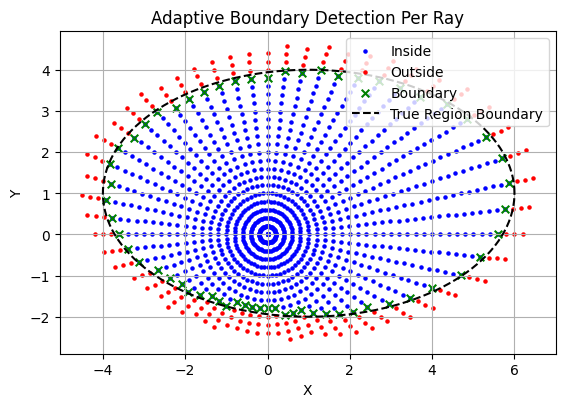

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class RadialBoundaryTracer:
    def __init__(self, center, max_radius, step_size, angular_resolution, is_point_in_region_func, outside_streak=3):
        self.center = np.array(center)
        self.max_radius = max_radius
        self.step_size = step_size
        self.angular_resolution = angular_resolution
        self.is_point_in_region_func = is_point_in_region_func
        self.outside_streak = outside_streak  # How many outside points before we assume we're past the boundary

    def trace_boundary(self):
        boundary_points = []
        inside_points = []
        outside_points = []

        angles = np.linspace(0, 2 * np.pi, self.angular_resolution, endpoint=False)

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            consecutive_outside = 0
            last_inside = None

            while radius <= self.max_radius:
                point = self.center + radius * direction
                if self.is_point_in_region_func(point):
                    inside_points.append(point)
                    last_inside = point
                    consecutive_outside = 0
                else:
                    outside_points.append(point)
                    consecutive_outside += 1

                if consecutive_outside >= self.outside_streak:
                    if last_inside is not None:
                        boundary_points.append(last_inside)
                    break

                radius += self.step_size

        return (
            np.array(inside_points),
            np.array(outside_points),
            np.array(boundary_points)
        )



# Plotting
def plot_results(inside, outside, boundary, center, region_radii):
    fig, ax = plt.subplots()
    if inside.size > 0:
        ax.scatter(inside[:, 0], inside[:, 1], c='blue', s=5, label='Inside')
    if outside.size > 0:
        ax.scatter(outside[:, 0], outside[:, 1], c='red', s=5, label='Outside')
    if boundary.size > 0:
        ax.scatter(boundary[:, 0], boundary[:, 1], c='green', s=30, marker='x', label='Boundary')

    # True region boundary (ellipse)
    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + region_radii[0] * np.cos(theta)
    y_boundary = center[1] + region_radii[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='True Region Boundary')

    ax.set_aspect('equal')
    ax.legend()
    ax.set_title("Adaptive Boundary Detection Per Ray")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()
# Example elliptical region
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_ellipsoid(point):
    rel = (point - actual_center) / ellipsoid_radii
    return np.sum(rel**2) <= 1

# Usage
tracer = RadialBoundaryTracer(
    center=[0, 0],
    max_radius=10,
    step_size=0.2,
    angular_resolution=60,
    is_point_in_region_func=is_inside_ellipsoid
)

inside_pts, outside_pts, boundary_pts = tracer.trace_boundary()
plot_results(inside_pts, outside_pts, boundary_pts, actual_center, ellipsoid_radii)


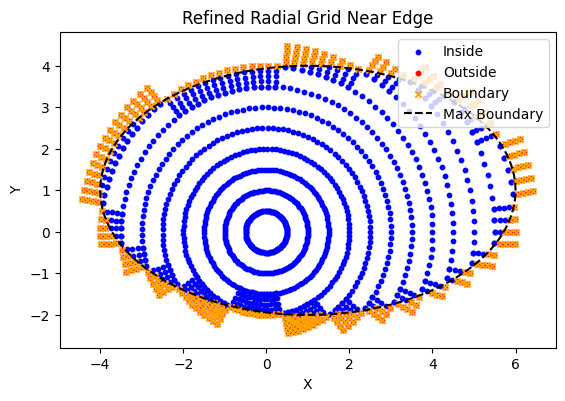

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        angles = np.linspace(0, 2 * np.pi, int(2 * np.pi * max(self.max_radius) / self.point_spacing), endpoint=False)
        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            found_transition = False
            prev_point = self.center.copy()
            prev_inside = self.is_point_in_region_func(prev_point)

            while radius < max(self.max_radius):
                radius += self.initial_step_size
                point = self.center + direction * radius
                inside = self.is_point_in_region_func(point)

                if inside:
                    if not found_transition:
                        all_points_inside.append(point)
                    prev_point = point
                    prev_inside = True
                else:
                    if prev_inside:
                        # Transition detected: refine in this angular direction
                        found_transition = True
                        # Refine between prev_point and point
                        for i in range(1, self.refinement_factor + 1):
                            interp_radius = radius - i * (self.initial_step_size / self.refinement_factor)
                            interp_point = self.center + direction * interp_radius
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                        break  # stop further expansion in this direction
                    else:
                        all_points_outside.append(point)
                        break

        return np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)


def plot_radial_grid(points_inside, points_outside, boundary_points, center, max_radius):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge")
    ax.legend()
    plt.show()


# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, boundary_points = grid_gen.generate_grid()
plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, max_radius=ellipsoid_radii)


need to find the boundary when not circular

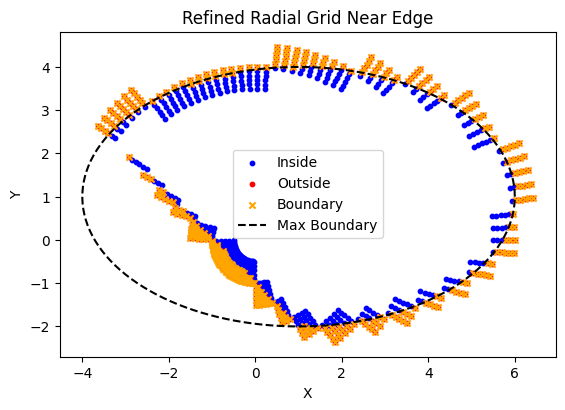

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        num_angles = int(2 * np.pi * max(self.max_radius) / self.point_spacing)
        angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            step = self.initial_step_size

            last_inside_point = None
            found_boundary = False

            while radius < max(self.max_radius):
                point = self.center + direction * radius
                inside = self.is_point_in_region_func(point)

                if inside:
                    last_inside_point = point
                    radius += step
                else:
                    if last_inside_point is not None:
                        # Refine between last inside and current outside
                        for i in range(1, self.refinement_factor + 1):
                            t = i / (self.refinement_factor + 1)
                            interp_point = (1 - t) * last_inside_point + t * point
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_inside.append(last_inside_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                    else:
                        all_points_outside.append(point)
                    break  # Stop in this direction after detecting boundary

        return np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)



def plot_radial_grid(points_inside, points_outside, boundary_points, center, max_radius):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge")
    ax.legend()
    plt.show()


# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    if np.sum(point)<-1:
        return False
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, boundary_points = grid_gen.generate_grid()
plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, max_radius=ellipsoid_radii)


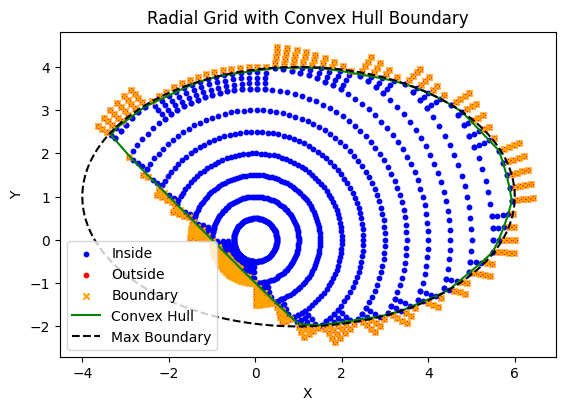

In [9]:
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        angles = np.linspace(0, 2 * np.pi, int(2 * np.pi * max(self.max_radius) / self.point_spacing), endpoint=False)
        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            found_transition = False
            prev_point = self.center.copy()
            prev_inside = self.is_point_in_region_func(prev_point)

            while radius < max(self.max_radius):
                radius += self.initial_step_size
                point = self.center + direction * radius
                inside = self.is_point_in_region_func(point)

                if inside:
                    if not found_transition:
                        all_points_inside.append(point)
                    prev_point = point
                    prev_inside = True
                else:
                    if prev_inside:
                        # Transition detected: refine in this angular direction
                        found_transition = True
                        # Refine between prev_point and point
                        for i in range(1, self.refinement_factor + 1):
                            interp_radius = radius - i * (self.initial_step_size / self.refinement_factor)
                            interp_point = self.center + direction * interp_radius
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                        break  # stop further expansion in this direction
                    else:
                        all_points_outside.append(point)
                        break

        return np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)

    def compute_convex_hull(self, points):
        if len(points) >= 3:  # Convex hull requires at least 3 points
            hull = ConvexHull(points)
            return points[hull.vertices]
        return np.array([])

def plot_radial_grid(points_inside, points_outside, boundary_points, hull_points, center, max_radius):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    # Plot convex hull (if available)
    if hull_points.size > 0:
        ax.plot(np.append(hull_points[:, 0], hull_points[0, 0]), np.append(hull_points[:, 1], hull_points[0, 1]), 'g-', label='Convex Hull')

    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Radial Grid with Convex Hull Boundary")
    ax.legend()
    plt.show()

# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    if np.sum(point) < -1:
        return False
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, boundary_points = grid_gen.generate_grid()
hull_points = grid_gen.compute_convex_hull(points_inside)

plot_radial_grid(points_inside, points_outside, boundary_points, hull_points, center=actual_center, max_radius=ellipsoid_radii)


scale convex hull

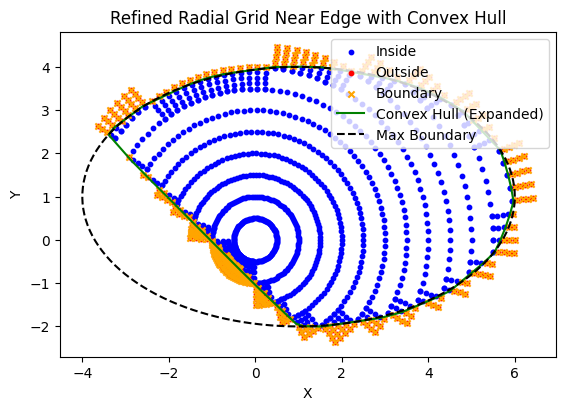

In [10]:
from scipy.spatial import ConvexHull
import numpy as np
import matplotlib.pyplot as plt

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        angles = np.linspace(0, 2 * np.pi, int(2 * np.pi * max(self.max_radius) / self.point_spacing), endpoint=False)
        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            found_transition = False
            prev_point = self.center.copy()
            prev_inside = self.is_point_in_region_func(prev_point)

            while radius < max(self.max_radius):
                radius += self.initial_step_size
                point = self.center + direction * radius
                inside = self.is_point_in_region_func(point)

                if inside:
                    if not found_transition:
                        all_points_inside.append(point)
                    prev_point = point
                    prev_inside = True
                else:
                    if prev_inside:
                        # Transition detected: refine in this angular direction
                        found_transition = True
                        # Refine between prev_point and point
                        for i in range(1, self.refinement_factor + 1):
                            interp_radius = radius - i * (self.initial_step_size / self.refinement_factor)
                            interp_point = self.center + direction * interp_radius
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                        break  # stop further expansion in this direction
                    else:
                        all_points_outside.append(point)
                        break

        return np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)

def expand_convex_hull(hull_points, expansion_factor=0.05):
    """Expand the convex hull by a small factor to make it slightly larger."""
    hull_center = np.mean(hull_points, axis=0)
    expanded_points = []
    
    for point in hull_points:
        direction = point - hull_center
        expanded_point = point + direction * expansion_factor
        expanded_points.append(expanded_point)
    
    return np.array(expanded_points)

def plot_radial_grid(points_inside, points_outside, boundary_points, center, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'g-', label='Convex Hull (Expanded)')

    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull")
    ax.legend()
    plt.show()

# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    if np.sum(point) < -1:
        return False
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot everything
plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)


just find the boundary and calculate the convex hull

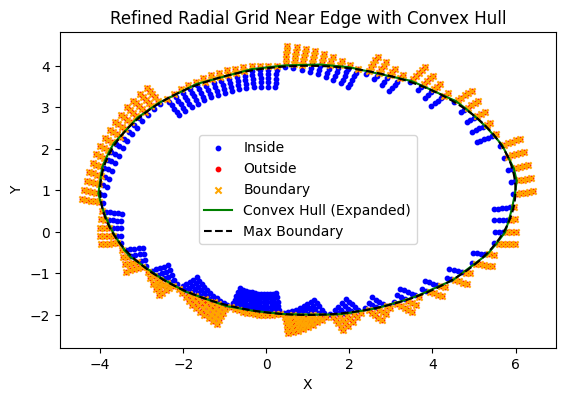

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        num_angles = int(2 * np.pi * max(self.max_radius) / self.point_spacing)
        angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            step = self.initial_step_size

            last_inside_point = None
            found_boundary = False

            while radius < max(self.max_radius):
                point = self.center + direction * radius
                inside = self.is_point_in_region_func(point)

                if inside:
                    last_inside_point = point
                    radius += step
                else:
                    if last_inside_point is not None:
                        # Refine between last inside and current outside
                        for i in range(1, self.refinement_factor + 1):
                            t = i / (self.refinement_factor + 1)
                            interp_point = (1 - t) * last_inside_point + t * point
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_inside.append(last_inside_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                    else:
                        all_points_outside.append(point)
                    break  # Stop in this direction after detecting boundary

        return np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)


def expand_convex_hull(hull_points, expansion_factor=0.05):
    """Expand the convex hull by a small factor to make it slightly larger."""
    hull_center = np.mean(hull_points, axis=0)
    expanded_points = []
    
    for point in hull_points:
        direction = point - hull_center
        expanded_point = point + direction * expansion_factor
        expanded_points.append(expanded_point)
    
    return np.array(expanded_points)

def plot_radial_grid(points_inside, points_outside, boundary_points, center, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'g-', label='Convex Hull (Expanded)')

    theta = np.linspace(0, 2 * np.pi, 300)
    x_boundary = center[0] + max_radius[0] * np.cos(theta)
    y_boundary = center[1] + max_radius[1] * np.sin(theta)
    ax.plot(x_boundary, y_boundary, 'k--', label='Max Boundary')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull")
    ax.legend()
    plt.show()


# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot everything
plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)


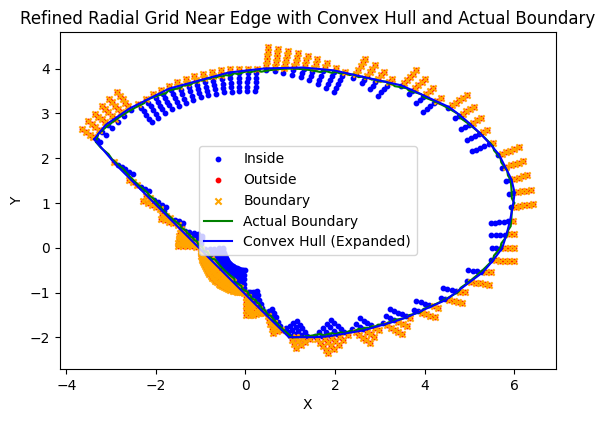

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        num_angles = int(2 * np.pi * max(self.max_radius) / self.point_spacing)
        angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            step = self.initial_step_size

            last_inside_point = None
            found_boundary = False

            while radius < max(self.max_radius):
                point = self.center + direction * radius
                inside = self.is_point_in_region_func(point)

                if inside:
                    last_inside_point = point
                    radius += step
                else:
                    if last_inside_point is not None:
                        # Refine between last inside and current outside
                        for i in range(1, self.refinement_factor + 1):
                            t = i / (self.refinement_factor + 1)
                            interp_point = (1 - t) * last_inside_point + t * point
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_inside.append(last_inside_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                    else:
                        all_points_outside.append(point)
                    break  # Stop in this direction after detecting boundary

        return np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)


def expand_convex_hull(hull_points, expansion_factor=0.05):
    """Expand the convex hull by a small factor to make it slightly larger."""
    hull_center = np.mean(hull_points, axis=0)
    expanded_points = []
    
    for point in hull_points:
        direction = point - hull_center
        expanded_point = point + direction * expansion_factor
        expanded_points.append(expanded_point)
    
    return np.array(expanded_points)

def plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    # Plot the actual boundary using is_inside_region
    boundary_angles = np.linspace(0, 2 * np.pi, 300)
    boundary_points = []
    for angle in boundary_angles:
        direction = np.array([np.cos(angle), np.sin(angle)])
        radius = 0
        # Move along the direction and find the transition from inside to outside
        while True:
            point = center + direction * radius
            if is_inside_region_func(point):
                radius += 0.05  # Small increment
            else:
                boundary_points.append(center + direction * (radius - 0.05))
                break

    boundary_points = np.array(boundary_points)

    if boundary_points.size > 0:
        ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'g-', label='Actual Boundary')

    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'b-', label='Convex Hull (Expanded)')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull and Actual Boundary")
    ax.legend()
    plt.show()


# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])


def is_inside_region(point):
    if np.sum(point) < -1:
        return False
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot everything
plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)


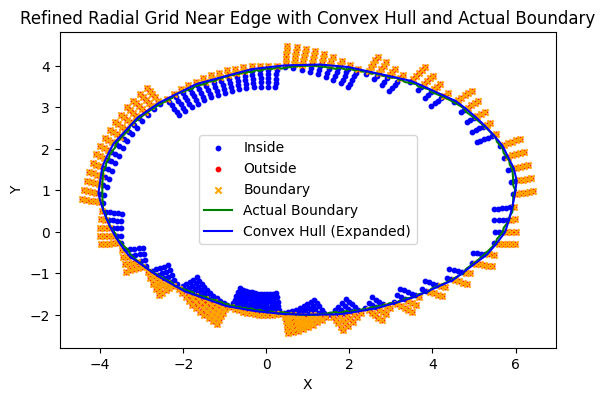

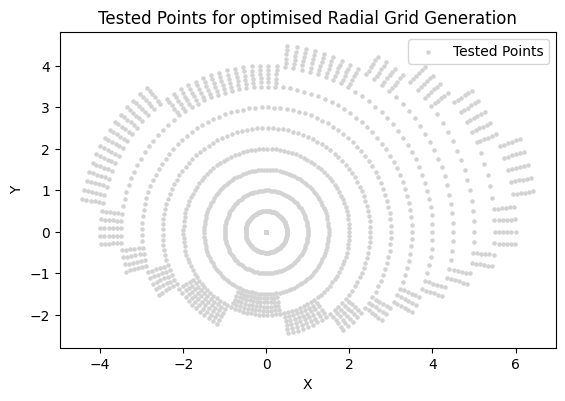

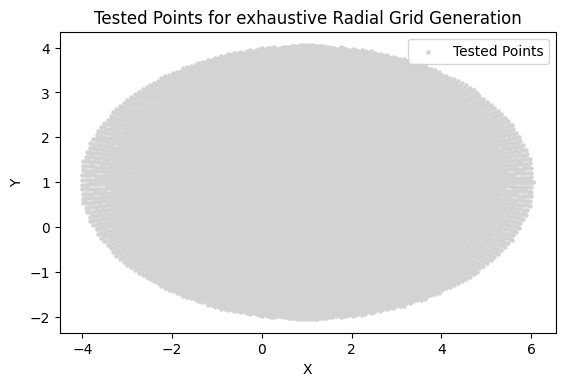

optimised tested points: (1603, 2), Exhaustive radial search: (23342, 2)
Improved by factor of 1456.14%


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = np.array(max_radius)
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        num_angles = int(2 * np.pi * max(self.max_radius) / self.point_spacing)
        angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

        all_points_tested = []  # Collect all points tested
        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            step = self.initial_step_size

            last_inside_point = None
            found_boundary = False

            while radius < max(self.max_radius):
                point = self.center + direction * radius
                all_points_tested.append(point)  # Track all points tested
                inside = self.is_point_in_region_func(point)

                if inside:
                    last_inside_point = point
                    radius += step
                else:
                    if last_inside_point is not None:
                        # Refine between last inside and current outside
                        for i in range(1, self.refinement_factor + 1):
                            t = i / (self.refinement_factor + 1)
                            interp_point = (1 - t) * last_inside_point + t * point
                            all_points_tested.append(interp_point)  # Track refined points
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_inside.append(last_inside_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                    else:
                        all_points_outside.append(point)
                    break  # Stop in this direction after detecting boundary

        return np.array(all_points_tested), np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)

def plot_tested_points(points_tested, title):
    fig, ax = plt.subplots()

    # Plot all tested points in light gray
    if points_tested.size > 0:
        ax.scatter(points_tested[:, 0], points_tested[:, 1], c='lightgray', label='Tested Points', s=5)

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    # Plot the actual boundary using is_inside_region
    boundary_angles = np.linspace(0, 2 * np.pi, 300)
    boundary_points = []
    tested_points = []
    for angle in boundary_angles:
        direction = np.array([np.cos(angle), np.sin(angle)])
        radius = 0
        # Move along the direction and find the transition from inside to outside
        while True:
            point = center + direction * radius
            tested_points.append(point)
            if is_inside_region_func(point):
                radius += 0.05  # Small increment
            else:
                boundary_points.append(center + direction * (radius - 0.05))
                break

    boundary_points = np.array(boundary_points)

    if boundary_points.size > 0:
        ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'g-', label='Actual Boundary')

    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'b-', label='Convex Hull (Expanded)')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull and Actual Boundary")
    ax.legend()
    plt.show()

    return np.array(tested_points)


# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])


def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)



# Plot the radial grid with boundary, inside, and outside points
tested_points = plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)

# Plot tested points
plot_tested_points(points_tested, title="Tested Points for optimised Radial Grid Generation")
plot_tested_points(tested_points, title="Tested Points for exhaustive Radial Grid Generation")

print(f"optimised tested points: {points_tested.shape}, Exhaustive radial search: {tested_points.shape}")
print(f"Improved by factor of {100*tested_points.shape[0]/points_tested.shape[0]:.2f}%")

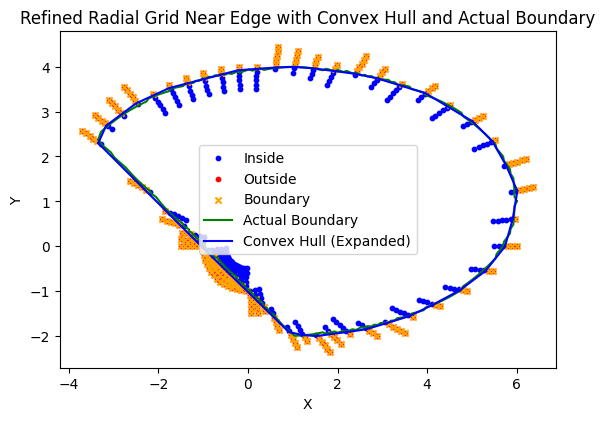

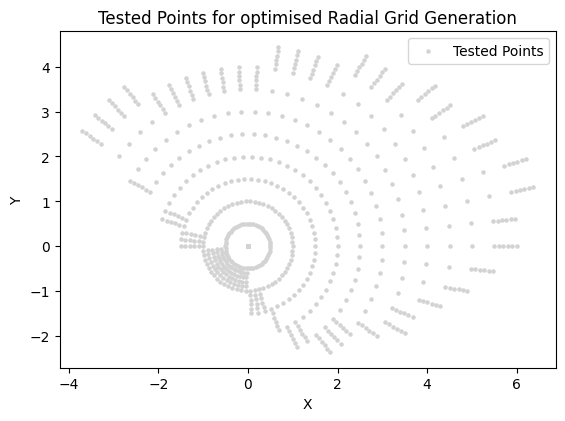

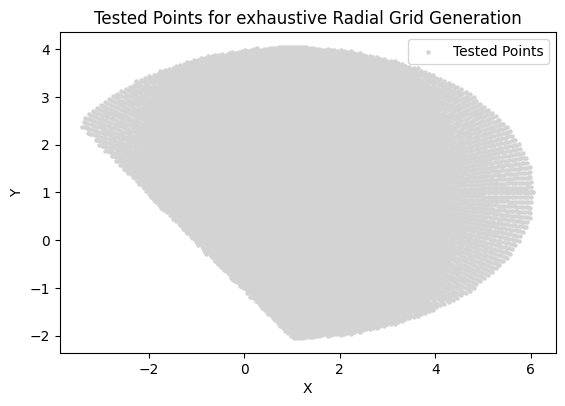

optimised tested points: (711, 2), Exhaustive radial search: (20852, 2)
Improved by factor of 2932.77%


In [14]:
# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])


def is_inside_region(point):
    if np.sum(point)<-1:
        return False
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=[10, 10],
    initial_step_size=0.5,
    point_spacing=1,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)



# Plot the radial grid with boundary, inside, and outside points
tested_points = plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)

# Plot tested points
plot_tested_points(points_tested, title="Tested Points for optimised Radial Grid Generation")
plot_tested_points(tested_points, title="Tested Points for exhaustive Radial Grid Generation")

print(f"optimised tested points: {points_tested.shape}, Exhaustive radial search: {tested_points.shape}")
print(f"Improved by factor of {100*tested_points.shape[0]/points_tested.shape[0]:.2f}%")

 too many points near center, maybe we do better?

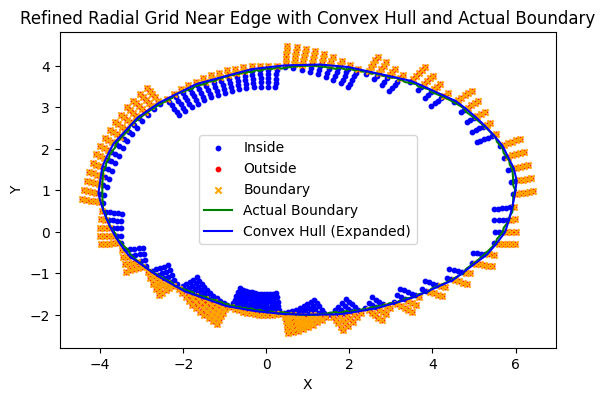

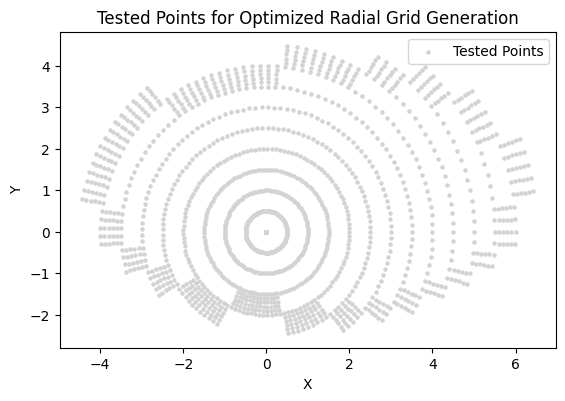

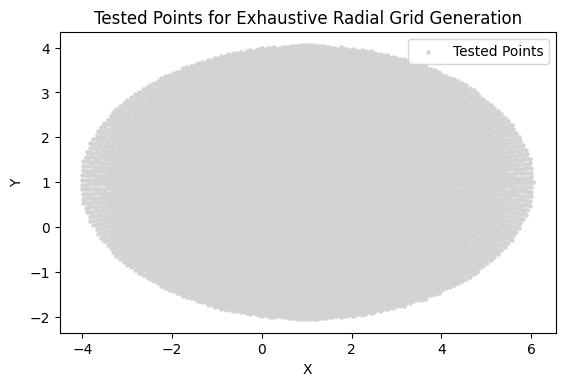

Optimized tested points: (1603, 2), Exhaustive radial search: (23342, 2)
Improved by a factor of 1456.14%


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = max_radius
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func

    def generate_grid(self):
        num_angles = int(2 * np.pi * self.max_radius / self.point_spacing)
        angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

        all_points_tested = []  # Collect all points tested
        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = 0
            step = self.initial_step_size

            last_inside_point = None
            found_boundary = False

            while radius < self.max_radius:
                point = self.center + direction * radius
                all_points_tested.append(point)  # Track all points tested
                inside = self.is_point_in_region_func(point)

                if inside:
                    last_inside_point = point
                    radius += step
                else:
                    if last_inside_point is not None:
                        # Refine between last inside and current outside
                        for i in range(1, self.refinement_factor + 1):
                            t = i / (self.refinement_factor + 1)
                            interp_point = (1 - t) * last_inside_point + t * point
                            all_points_tested.append(interp_point)  # Track refined points
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        all_points_inside.append(last_inside_point)
                        all_points_outside.append(point)
                        boundary_points.append(point)
                    else:
                        all_points_outside.append(point)
                    break  # Stop in this direction after detecting boundary

        return np.array(all_points_tested), np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)

def plot_tested_points(points_tested, title):
    fig, ax = plt.subplots()

    # Plot all tested points in light gray
    if points_tested.size > 0:
        ax.scatter(points_tested[:, 0], points_tested[:, 1], c='lightgray', label='Tested Points', s=5)

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    # Plot the actual boundary using is_inside_region
    boundary_angles = np.linspace(0, 2 * np.pi, 300)
    boundary_points = []
    tested_points = []
    for angle in boundary_angles:
        direction = np.array([np.cos(angle), np.sin(angle)])
        radius = 0
        # Move along the direction and find the transition from inside to outside
        while True:
            point = center + direction * radius
            tested_points.append(point)
            if is_inside_region_func(point):
                radius += 0.05  # Small increment
            else:
                boundary_points.append(center + direction * (radius - 0.05))
                break

    boundary_points = np.array(boundary_points)

    if boundary_points.size > 0:
        ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'g-', label='Actual Boundary')

    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'b-', label='Convex Hull (Expanded)')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull and Actual Boundary")
    ax.legend()
    plt.show()

    return np.array(tested_points)


# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])


def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=10,  # Maximum radius for grid generation
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot the radial grid with boundary, inside, and outside points
tested_points = plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)

# Plot tested points
plot_tested_points(points_tested, title="Tested Points for Optimized Radial Grid Generation")
plot_tested_points(tested_points, title="Tested Points for Exhaustive Radial Grid Generation")

print(f"Optimized tested points: {points_tested.shape}, Exhaustive radial search: {tested_points.shape}")
print(f"Improved by a factor of {100*tested_points.shape[0]/points_tested.shape[0]:.2f}%")


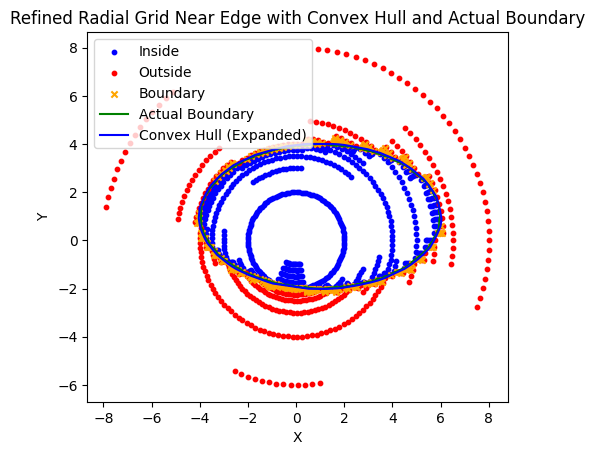

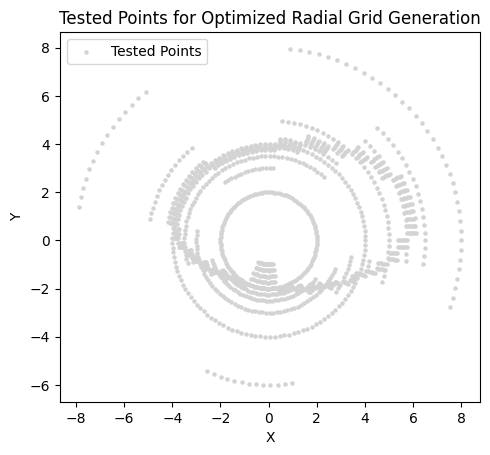

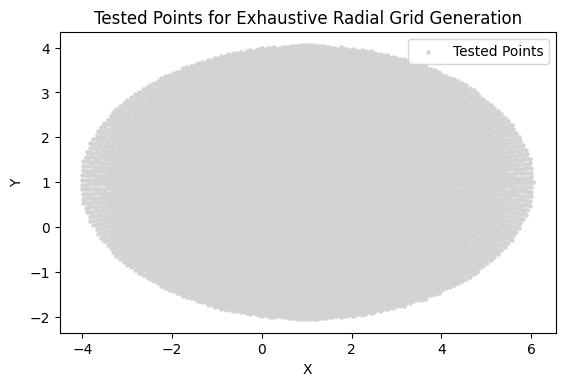

Optimized tested points: (1255, 2), Exhaustive radial search: (23342, 2)
Improved by a factor of 1859.92%


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class RadialGrid:
    def __init__(self, center, max_radius, initial_step_size, point_spacing, k=4, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = max_radius
        self.initial_step_size = initial_step_size
        self.point_spacing = point_spacing
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func
        self.k=k

    def generate_grid(self):
        num_angles = int(2 * np.pi * self.max_radius / self.point_spacing)
        angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

        all_points_tested = []  # Collect all points tested
        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            radius = self.k*self.initial_step_size
            step = self.initial_step_size

            last_inside_point = None
            inner_radius = radius
            first_outside_point = None
            outer_radius = self.max_radius
            found_boundary = False

            while radius < self.max_radius:
                point = self.center + direction * radius
                all_points_tested.append(point)  # Track all points tested
                inside = self.is_point_in_region_func(point)

                if inside:
                    all_points_inside.append(point)
                    last_inside_point = point
                    if first_outside_point is None:
                        radius*=2  # double no outside bound yet
                    else:
                        # there is an upper bound
                        inner_radius = max(inner_radius, radius)
                        radius = (outer_radius+inner_radius)/2
                else:
                    # If outside, reduce step size and check closer to the center
                    all_points_outside.append(point)
                    first_outside_point = point
                    if last_inside_point is None:
                        # overshoot
                        radius/=2
                    else:
                        # there is a lower bound
                        outer_radius = min(outer_radius, radius)
                        radius =(outer_radius+inner_radius)/2

                        
                # outer inner radius hit the limit we have smallest boundary
                if last_inside_point is not None and first_outside_point is not None and np.abs(outer_radius-inner_radius)<self.initial_step_size:
                    # Refine the boundary detection by checking smaller radii
                    for i in range(1, self.refinement_factor + 1):
                        t = i / (self.refinement_factor + 1)
                        interp_point = (1 - t) * last_inside_point + t * first_outside_point
                        all_points_tested.append(interp_point)  # Track refined points
                        if self.is_point_in_region_func(interp_point):
                            all_points_inside.append(interp_point)
                        else:
                            all_points_outside.append(interp_point)
                            boundary_points.append(interp_point)
                    break  # Stop in this direction after detecting boundary

        return np.array(all_points_tested), np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)

def plot_tested_points(points_tested, title):
    fig, ax = plt.subplots()

    # Plot all tested points in light gray
    if points_tested.size > 0:
        ax.scatter(points_tested[:, 0], points_tested[:, 1], c='lightgray', label='Tested Points', s=5)

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    # Plot the actual boundary using is_inside_region
    boundary_angles = np.linspace(0, 2 * np.pi, 300)
    boundary_points = []
    tested_points = []
    for angle in boundary_angles:
        direction = np.array([np.cos(angle), np.sin(angle)])
        radius = 0
        # Move along the direction and find the transition from inside to outside
        while True:
            point = center + direction * radius
            tested_points.append(point)
            if is_inside_region_func(point):
                radius += 0.05  # Small increment
            else:
                boundary_points.append(center + direction * (radius - 0.05))
                break

    boundary_points = np.array(boundary_points)

    if boundary_points.size > 0:
        ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'g-', label='Actual Boundary')

    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'b-', label='Convex Hull (Expanded)')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull and Actual Boundary")
    ax.legend()
    plt.show()

    return np.array(tested_points)


# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([5, 3])


def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[0, 0],
    max_radius=10,  # Maximum radius for grid generation
    initial_step_size=0.5,
    point_spacing=0.5,
    refinement_factor=4,
    is_point_in_region_func=is_inside_region
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot the radial grid with boundary, inside, and outside points
tested_points = plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)

# Plot tested points
plot_tested_points(points_tested, title="Tested Points for Optimized Radial Grid Generation")
plot_tested_points(tested_points, title="Tested Points for Exhaustive Radial Grid Generation")

print(f"Optimized tested points: {points_tested.shape}, Exhaustive radial search: {tested_points.shape}")
print(f"Improved by a factor of {100*tested_points.shape[0]/points_tested.shape[0]:.2f}%")


lets do better than just randomly //2 and *2

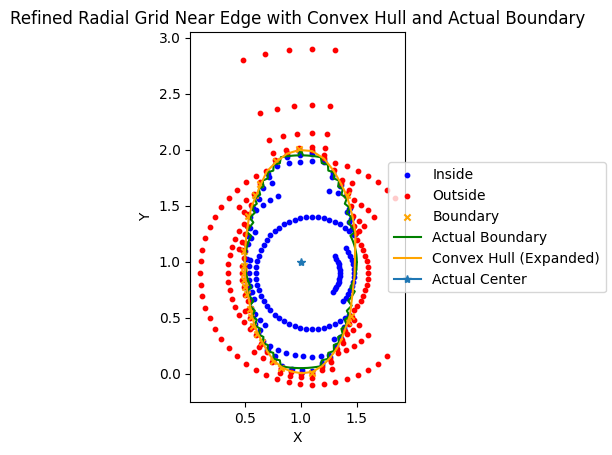

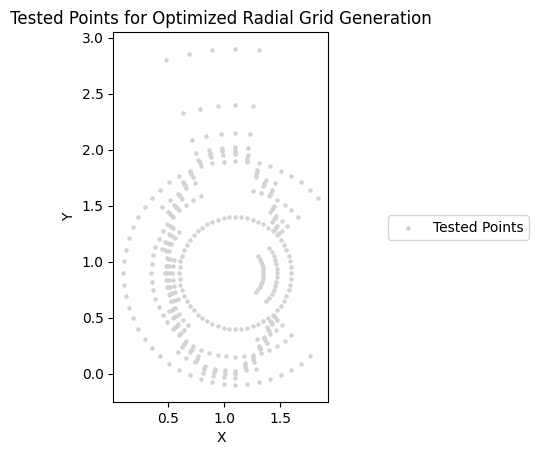

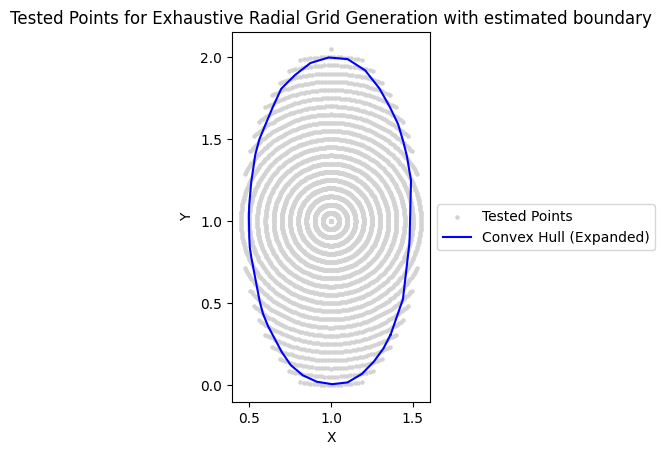

Optimized tested points: (374, 2), Exhaustive radial search: (4587, 2)
Improved by a factor of 1226.47%


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class RadialGrid:
    def __init__(self, center, max_radius, boundary_tolerance=0.1, angular_resolution=60, k=4, refinement_factor=3, is_point_in_region_func=None):
        self.center = np.array(center)
        self.max_radius = max_radius
        self.angular_resolution = angular_resolution
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func
        self.k = k
        self.boundary_tolerance = boundary_tolerance

    def generate_grid(self):
            angles = np.linspace(0, 2 * np.pi, self.angular_resolution, endpoint=False)

            all_points_tested = []
            all_points_inside = []
            all_points_outside = []
            boundary_points = []

            for angle in angles:
                direction = np.array([np.cos(angle), np.sin(angle)])
                radius = self.k

                last_inside_point = None
                inner_radius = radius
                first_outside_point = None
                outer_radius = None
                found_boundary = False

                while radius < self.max_radius:
                    point = self.center + direction * radius
                    all_points_tested.append(point)
                    inside = self.is_point_in_region_func(point)

                    if inside:
                        all_points_inside.append(point)
                        last_inside_point = point
                        inner_radius = max(inner_radius, radius)
                        if first_outside_point is None:
                            radius *= 2  # Double step if no outside bound yet
                        else:
                            radius = (outer_radius + inner_radius) / 2  # Binary search-like approach
                    else:
                        all_points_outside.append(point)
                        first_outside_point = point
                        if outer_radius is None:
                                outer_radius = radius
                        outer_radius = min(outer_radius, radius)
                        if last_inside_point is None:
                            radius /= 2  # Halve step if overshoot
                        else:
                            radius = (outer_radius + inner_radius) / 2  # Refined step

                    # Perform boundary refinement when inner and outer radius are close enough
                    if last_inside_point is not None and first_outside_point is not None and np.abs(outer_radius - inner_radius) < self.boundary_tolerance:
                        for i in range(1, self.refinement_factor + 1):
                            t = i / (self.refinement_factor + 1)
                            interp_point = (1 - t) * last_inside_point + t * first_outside_point
                            all_points_tested.append(interp_point)
                            if self.is_point_in_region_func(interp_point):
                                all_points_inside.append(interp_point)
                            else:
                                all_points_outside.append(interp_point)
                                boundary_points.append(interp_point)
                        break

            return np.array(all_points_tested), np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)

def plot_tested_points(points_tested, title, convex_hull=None):
    fig, ax = plt.subplots()

    # Plot all tested points in light gray
    if points_tested.size > 0:
        ax.scatter(points_tested[:, 0], points_tested[:, 1], c='lightgray', label='Tested Points', s=5)
    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'b-', label='Convex Hull (Expanded)')


    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    fig.legend(loc='center right')
    plt.show()

def plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    # Plot the actual boundary using is_inside_region
    boundary_angles = np.linspace(0, 2 * np.pi, 300, endpoint=False)
    boundary_points = []
    tested_points = []
    for angle in boundary_angles:
        direction = np.array([np.cos(angle), np.sin(angle)])
        radius = 0
        # Move along the direction and find the transition from inside to outside
        while True:
            point = center + direction * radius
            tested_points.append(point)
            if is_inside_region_func(point):
                radius += 0.05  # Small increment
            else:
                boundary_points.append(center + direction * (radius - 0.05))
                break

    boundary_points = np.array(boundary_points)

    if boundary_points.size > 0:
        ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'g-', label='Actual Boundary')

    if convex_hull is not None:
        # Plot convex hull
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], c='orange', linestyle='-', label='Convex Hull (Expanded)')

    ax.plot(center[0], center[1], label='Actual Center', marker='*')
    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull and Actual Boundary")
    fig.legend(loc='center right')
    plt.show()

    return np.array(tested_points)

def expand_convex_hull(hull_points, expansion_factor=0.05):
    """Expand the convex hull by a small factor to make it slightly larger."""
    hull_center = np.mean(hull_points, axis=0)
    expanded_points = []
    
    for point in hull_points:
        direction = point - hull_center
        expanded_point = point + direction * expansion_factor
        expanded_points.append(expanded_point)
    
    return np.array(expanded_points)
# Ellipsoidal Region (centered at [1, 1] with radii [5, 3])
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([0.5, 1])


def is_inside_region(point):
    # if np.sum(point)<-1 or np.sum(point)>5:
    #     return False
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

# Example usage
grid_gen = RadialGrid(
    center=[1.1,0.9],
    max_radius=100,  # Maximum radius for grid generation
    boundary_tolerance=0.05,
    angular_resolution=60,
    refinement_factor=1,
    k=0.5,
    is_point_in_region_func=is_inside_region
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot the radial grid with boundary, inside, and outside points
tested_points = plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)

# Plot tested points
plot_tested_points(points_tested, title="Tested Points for Optimized Radial Grid Generation")
plot_tested_points(tested_points, convex_hull=expanded_hull_points, title="Tested Points for Exhaustive Radial Grid Generation with estimated boundary")

print(f"Optimized tested points: {points_tested.shape}, Exhaustive radial search: {tested_points.shape}")
print(f"Improved by a factor of {100 * tested_points.shape[0] / points_tested.shape[0]:.2f}%")


N-dim

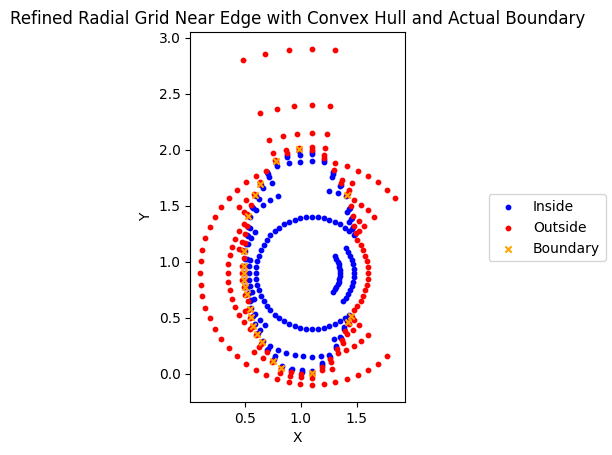

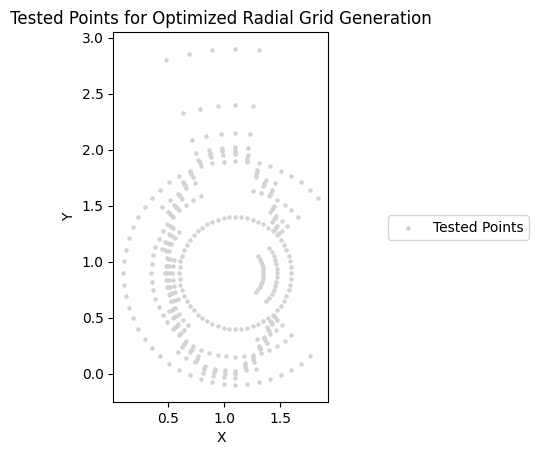

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

class RadialGrid:
    def __init__(self, center, max_radius, boundary_tolerance=0.1, angular_resolution=60, k=4, refinement_factor=3, is_point_in_region_func=None, dimensions=2):
        self.center = np.array(center)
        self.max_radius = max_radius
        self.angular_resolution = angular_resolution
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func
        self.k = k
        self.boundary_tolerance = boundary_tolerance
        self.dimensions = dimensions

    def generate_grid(self):
        # Adjusting for higher dimensions
        num_angles = self.angular_resolution
        angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)

        all_points_tested = []
        all_points_inside = []
        all_points_outside = []
        boundary_points = []

        # Iterate over angular directions in higher dimensions
        for angle in angles:
            direction = np.zeros(self.dimensions)
            if self.dimensions == 2:
                direction[0] = np.cos(angle)
                direction[1] = np.sin(angle)
            else:
                # Higher dimensional directions need to be sampled
                for i in range(self.dimensions):
                    direction[i] = np.cos(angle)  # Simplified for demo

            radius = self.k

            last_inside_point = None
            inner_radius = radius
            first_outside_point = None
            outer_radius = None
            found_boundary = False

            while radius < self.max_radius:
                point = self.center + direction * radius
                all_points_tested.append(point)
                inside = self.is_point_in_region_func(point)

                if inside:
                    all_points_inside.append(point)
                    last_inside_point = point
                    inner_radius = max(inner_radius, radius)
                    if first_outside_point is None:
                        radius *= 2  # Double step if no outside bound yet
                    else:
                        radius = (outer_radius + inner_radius) / 2  # Binary search-like approach
                else:
                    all_points_outside.append(point)
                    first_outside_point = point
                    if outer_radius is None:
                            outer_radius = radius
                    outer_radius = min(outer_radius, radius)
                    if last_inside_point is None:
                        radius /= 2  # Halve step if overshoot
                    else:
                        radius = (outer_radius + inner_radius) / 2  # Refined step

                # Perform boundary refinement when inner and outer radius are close enough
                if last_inside_point is not None and first_outside_point is not None and np.abs(outer_radius - inner_radius) < self.boundary_tolerance:
                    for i in range(1, self.refinement_factor + 1):
                        t = i / (self.refinement_factor + 1)
                        interp_point = (1 - t) * last_inside_point + t * first_outside_point
                        all_points_tested.append(interp_point)
                        if self.is_point_in_region_func(interp_point):
                            all_points_inside.append(interp_point)
                        else:
                            all_points_outside.append(interp_point)
                            boundary_points.append(interp_point)
                    break

        return np.array(all_points_tested), np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)

def plot_tested_points(points_tested, title, convex_hull=None):
    fig, ax = plt.subplots()

    if points_tested.size > 0:
        ax.scatter(points_tested[:, 0], points_tested[:, 1], c='lightgray', label='Tested Points', s=5)
    if convex_hull is not None:
        hull_points = np.vstack([convex_hull, convex_hull[0]])  # Connect the last point to the first
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'b-', label='Convex Hull (Expanded)')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    fig.legend(loc='center right')
    plt.show()

def plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, convex_hull=None):
    fig, ax = plt.subplots()

    if points_inside.size > 0:
        ax.scatter(points_inside[:, 0], points_inside[:, 1], c='blue', label='Inside', s=10)

    if points_outside.size > 0:
        ax.scatter(points_outside[:, 0], points_outside[:, 1], c='red', label='Outside', s=10)

    if boundary_points.size > 0:
        ax.scatter(boundary_points[:, 0], boundary_points[:, 1], c='orange', label='Boundary', s=20, marker='x')

    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Refined Radial Grid Near Edge with Convex Hull and Actual Boundary")
    fig.legend(loc='center right')
    plt.show()

    return np.array(points_inside)

# Example usage
actual_center = np.array([1, 1])
ellipsoid_radii = np.array([0.5, 1])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

grid_gen = RadialGrid(
    center=[1.1, 0.9],
    max_radius=100,
    boundary_tolerance=0.05,
    angular_resolution=60,
    refinement_factor=1,
    k=0.5,
    is_point_in_region_func=is_inside_region,
    dimensions=2
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()

# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot the radial grid with boundary, inside, and outside points
tested_points = plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=expanded_hull_points)

# Plot tested points
plot_tested_points(points_tested, title="Tested Points for Optimized Radial Grid Generation")


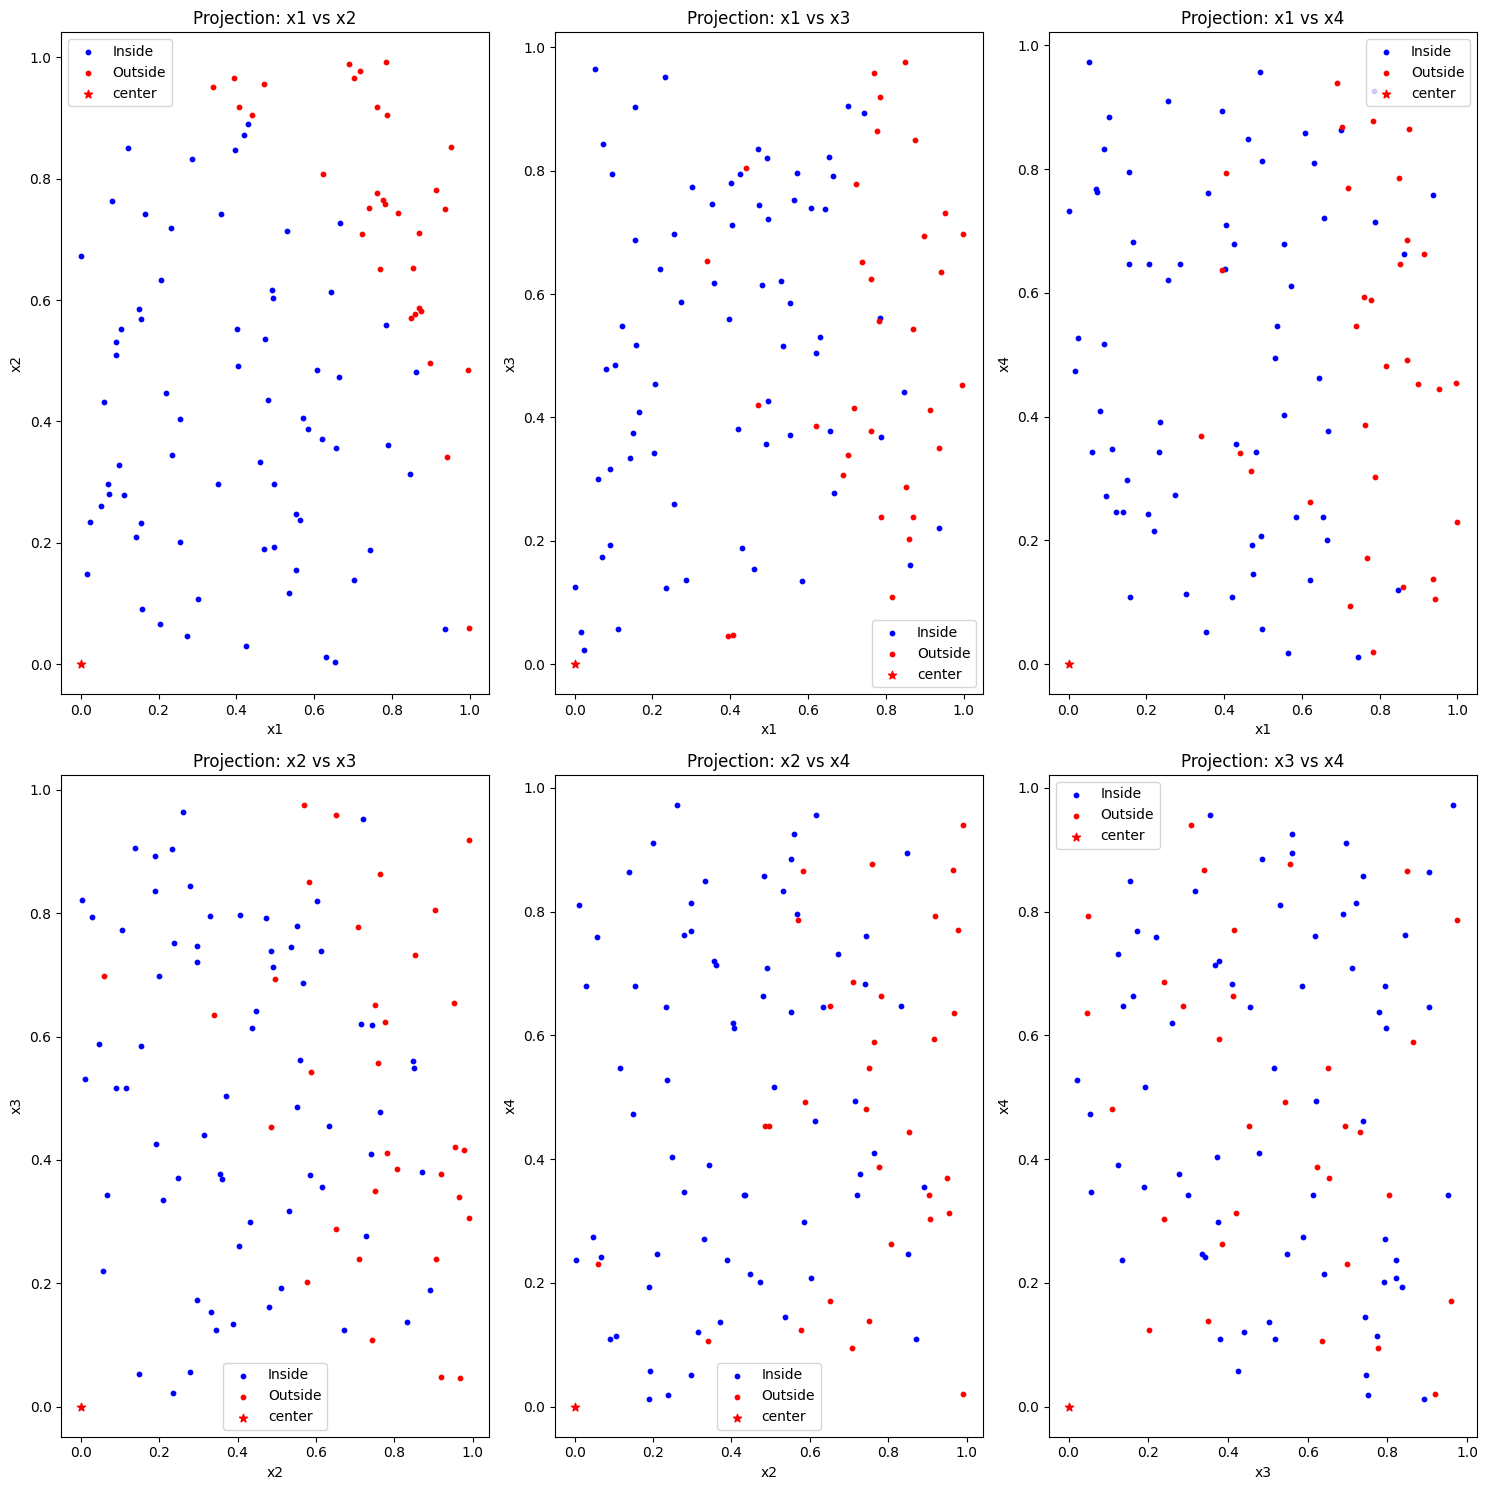

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, n_dims, convex_hull=None):
    """
    Function to plot the radial grid for n-dimensional data, visualizing projections in 2D subplots.
    
    Parameters:
    points_inside (numpy array): Points inside the region.
    points_outside (numpy array): Points outside the region.
    boundary_points (numpy array): Points on the boundary.
    center (numpy array): The center of the region (in n-dimensional space).
    is_inside_region_func (function): Function to check if a point is inside the region.
    max_radius (float): Maximum radius for the grid.
    n_dims (int): The number of dimensions for the grid.
    convex_hull (numpy array): Convex hull points (optional).
    """
    # Create a new figure with subplots
    num_combinations = len(list(combinations(range(n_dims), 2)))
    fig, axes = plt.subplots(nrows=(num_combinations // 3) + (num_combinations % 3 > 0), ncols=3, figsize=(15, 5 * (num_combinations // 3 + 1)))
    axes = axes.flatten()  # Flatten the axes array to handle cases with different subplot layouts

    # Generate combinations of dimensions to plot
    dim_combinations = list(combinations(range(n_dims), 2))
    
    # Plot projections of points in pairs of dimensions
    for idx, (dim1, dim2) in enumerate(dim_combinations):
        ax = axes[idx]
        
        # Plot points inside the region
        if points_inside.size > 0:
            ax.scatter(points_inside[:, dim1], points_inside[:, dim2], c='blue', label='Inside', s=10)

        # Plot points outside the region
        if points_outside is not None and points_outside.size > 0:
            ax.scatter(points_outside[:, dim1], points_outside[:, dim2], c='red', label='Outside', s=10)

        # Plot boundary points
        if boundary_points is not None and boundary_points.size > 0:
            ax.scatter(boundary_points[:, dim1], boundary_points[:, dim2], c='orange', label='Boundary', s=20, marker='x')
        
        ax.scatter(center[dim1], center[dim2], c='red', marker='*', label='center')
        ax.set_xlabel(f'x{dim1+1}')
        ax.set_ylabel(f'x{dim2+1}')
        ax.set_title(f'Projection: x{dim1+1} vs x{dim2+1}')
        ax.legend()

    # Turn off empty subplots if necessary
    for i in range(len(dim_combinations), len(axes)):
        axes[i].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Example usage for 4D data
n_dims = 4  # Change to 3 for 3D data or other dimensions

# Generate random 4D points
num_points = 100
points_4d = np.random.rand(num_points, n_dims)

# Define the inside region function for a simple ellipsoid (2D case for demonstration)
def is_inside_region(point):
    return np.sum(point**2) <= 1  # A unit circle in 2D

# Set a center and a max radius for the radial grid
center = np.array([0, 0, 0, 0])  # Center is now 4D
max_radius = 1.5

# For testing, generate points inside, outside, and boundary points (using some sample logic)
points_inside = points_4d[points_4d[:, 0]**2 + points_4d[:, 1]**2 <= 1]
points_outside = points_4d[points_4d[:, 0]**2 + points_4d[:, 1]**2 > 1]
boundary_points = points_4d[(points_4d[:, 0]**2 + points_4d[:, 1]**2 > 0.99) & (points_4d[:, 0]**2 + points_4d[:, 1]**2 <= 1)]

# Plot the radial grid (2D subset) and projections in subplots
plot_radial_grid(points_inside, points_outside, boundary_points, center, is_inside_region, max_radius, n_dims)


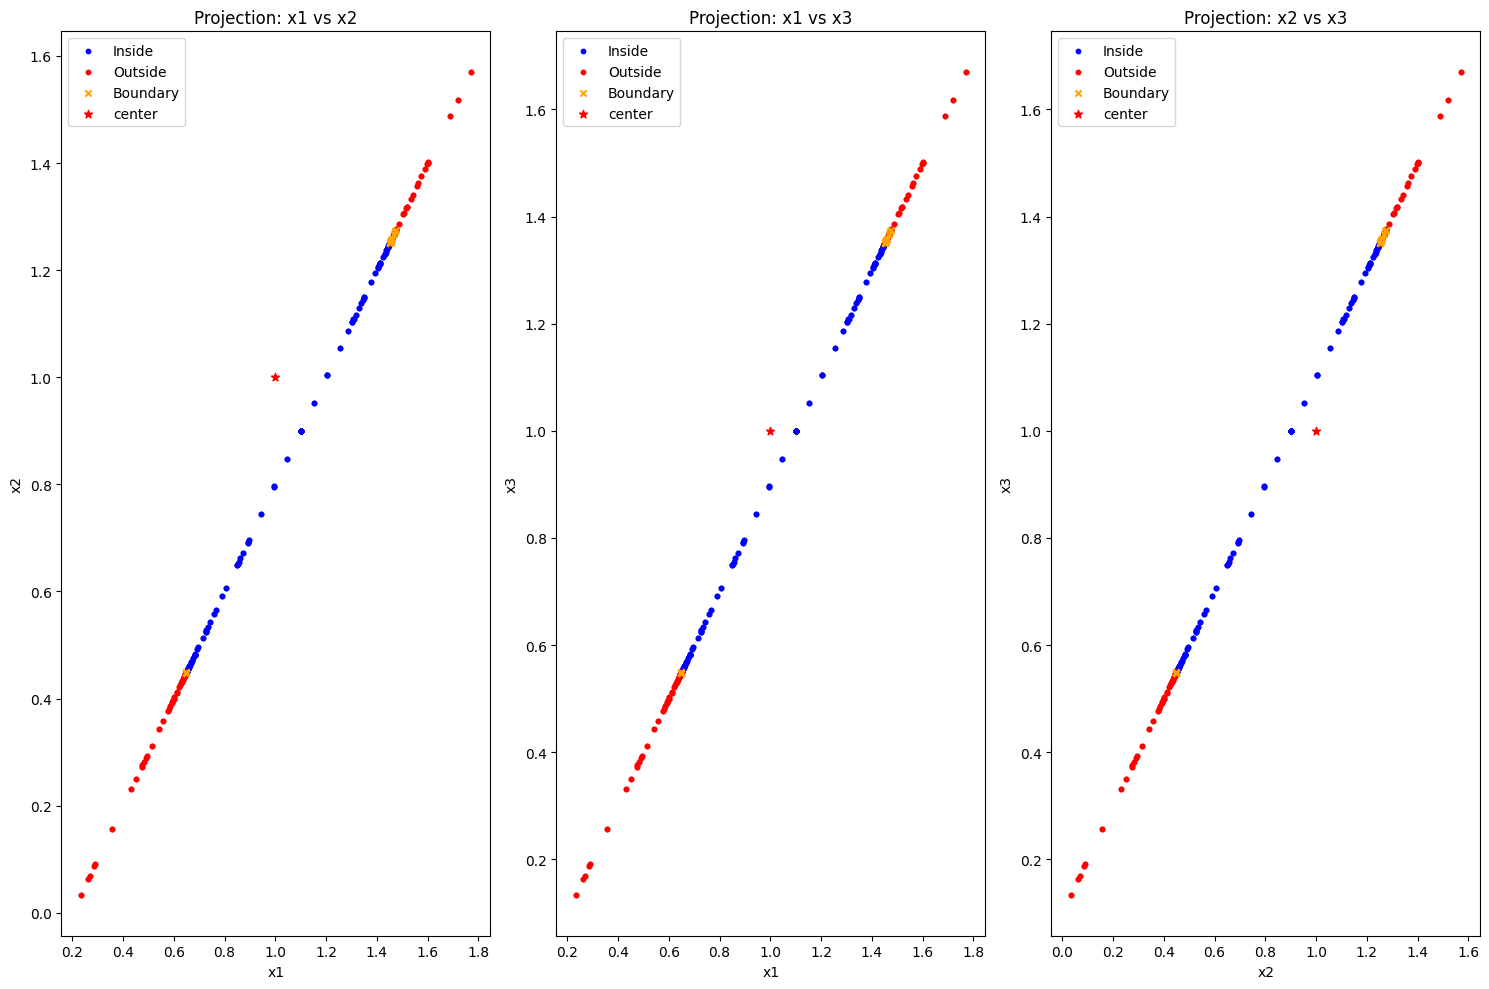

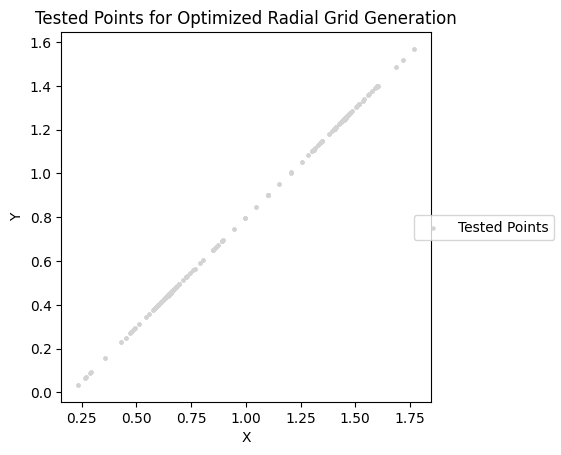

In [20]:
# Example usage
n_dims=3
actual_center = np.array([1, 1, 1])
ellipsoid_radii = np.array([0.5, 1, 1])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1

grid_gen = RadialGrid(
    center=[1.1, 0.9, 1],
    max_radius=100,
    boundary_tolerance=0.05,
    angular_resolution=60,
    refinement_factor=1,
    k=0.5,
    is_point_in_region_func=is_inside_region,
    dimensions=n_dims
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()
# # Fit a convex hull around inside points
# hull = ConvexHull(points_inside)

# # Optionally, expand the convex hull slightly
# expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot the radial grid with boundary, inside, and outside points
tested_points = plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, n_dims=n_dims)

# Plot tested points
plot_tested_points(points_tested, title="Tested Points for Optimized Radial Grid Generation")

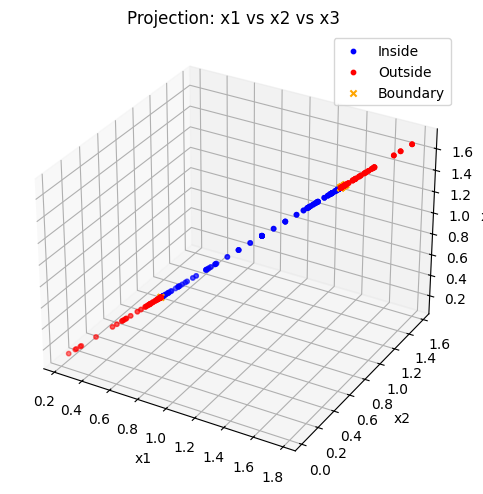

In [21]:
def plot_radial_grid_3d(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, n_dims, convex_hull=None):
    """
    Function to plot the radial grid for n-dimensional data in 3D projections.
    
    Parameters:
    points_inside (numpy array): Points inside the region.
    points_outside (numpy array): Points outside the region.
    boundary_points (numpy array): Points on the boundary.
    center (numpy array): The center of the region (in n-dimensional space).
    is_inside_region_func (function): Function to check if a point is inside the region.
    max_radius (float): Maximum radius for the grid.
    n_dims (int): The number of dimensions for the grid.
    convex_hull (numpy array): Convex hull points (optional).
    """
    # Generate all combinations of dimensions for plotting
    dim_combinations = list(combinations(range(n_dims), 3))
    
    # Calculate how many subplots are needed
    num_combinations = len(dim_combinations)
    rows = num_combinations // 2 + (num_combinations % 2 > 0)
    
    # Create a new figure with subplots
    fig = plt.figure(figsize=(15, 5 * rows))
    
    # Loop through the combinations and create 3D scatter plots
    for idx, (dim1, dim2, dim3) in enumerate(dim_combinations):
        ax = fig.add_subplot(rows, 2, idx + 1, projection='3d')
        
        # Plot points inside the region
        if points_inside.size > 0:
            ax.scatter(points_inside[:, dim1], points_inside[:, dim2], points_inside[:, dim3], c='blue', label='Inside', s=10)

        # Plot points outside the region
        if points_outside.size > 0:
            ax.scatter(points_outside[:, dim1], points_outside[:, dim2], points_outside[:, dim3], c='red', label='Outside', s=10)

        # Plot boundary points
        if boundary_points.size > 0:
            ax.scatter(boundary_points[:, dim1], boundary_points[:, dim2], boundary_points[:, dim3], c='orange', label='Boundary', s=20, marker='x')

        ax.set_xlabel(f'x{dim1+1}')
        ax.set_ylabel(f'x{dim2+1}')
        ax.set_zlabel(f'x{dim3+1}')
        ax.set_title(f'Projection: x{dim1+1} vs x{dim2+1} vs x{dim3+1}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

tested_points = plot_radial_grid_3d(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, n_dims=n_dims)


as it can be seen the setup works but its hard to get a direction for an nd space so we randomise it 

In [22]:
import numpy as np
from numba import jit

@jit(nopython=True)
def generate_unit_vectors(k, n_dim):
    """
    Function to generate k random unit vectors in n-dimensional space without checking for uniqueness.
    
    Parameters:
    k (int): The number of unit vectors to generate.
    n_dim (int): The dimensionality of the space.

    Returns:
    numpy array: A k x n_dim array containing k unit vectors.
    """
    # Generate k random vectors of size n_dim
    random_vectors = np.random.randn(k, n_dim)
    
    # Manually compute the L2 norm for each vector and normalize
    unit_vectors = np.zeros_like(random_vectors)
    
    for i in range(k):
        # Use numpy.linalg.norm() for individual vector norm
        norm = np.linalg.norm(random_vectors[i])
        
        # Normalize the vector
        unit_vectors[i] = random_vectors[i] / norm
    
    return unit_vectors

@jit(nopython=True)
def generate_random(k, n_dim):
    return np.random.randn(k, n_dim)

def generate_unit_vectors2(k, n_dim):
    """
    Function to generate k random unit vectors in n-dimensional space without checking for uniqueness.
    
    Parameters:
    k (int): The number of unit vectors to generate.
    n_dim (int): The dimensionality of the space.

    Returns:
    numpy array: A k x n_dim array containing k unit vectors.
    """
    # Generate k random vectors of size n_dim
    random_vectors = np.random.randn(k, n_dim)
    
    # Normalize each vector to have unit length using numpy.linalg.norm()
    norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
    unit_vectors = random_vectors / norms  # Element-wise division by the norm
    
    return unit_vectors

def generate_unit_vectors3(k, n_dim):
    """
    Function to generate k random unit vectors in n-dimensional space without checking for uniqueness.
    
    Parameters:
    k (int): The number of unit vectors to generate.
    n_dim (int): The dimensionality of the space.

    Returns:
    numpy array: A k x n_dim array containing k unit vectors.
    """
    # Generate k random vectors of size n_dim
    random_vectors = generate_random(k, n_dim)
    
    # Normalize each vector to have unit length using numpy.linalg.norm()
    norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
    unit_vectors = random_vectors / norms  # Element-wise division by the norm
    
    return unit_vectors

# Example usage
k = 400  # Number of unique unit vectors
n_dim = 6  # Dimensionality (e.g., 3 for 3D vectors)
unit_vectors = generate_unit_vectors(k, n_dim)

from cupyx.profiler import benchmark

# print(benchmark(generate_unit_vectors,(k, n_dim), n_repeat=1000))
# print(benchmark(generate_unit_vectors2,(k, n_dim), n_repeat=10000))
# print(benchmark(generate_unit_vectors3,(k, n_dim), n_repeat=10000))
# non jit is better as you can do batch normalisation


for i in unit_vectors:
    print(i)
    break

[ 0.01888963  0.6114892  -0.24471551 -0.37629777  0.40342563 -0.51135723]


For n_dim = 6, angular_resolution = 120


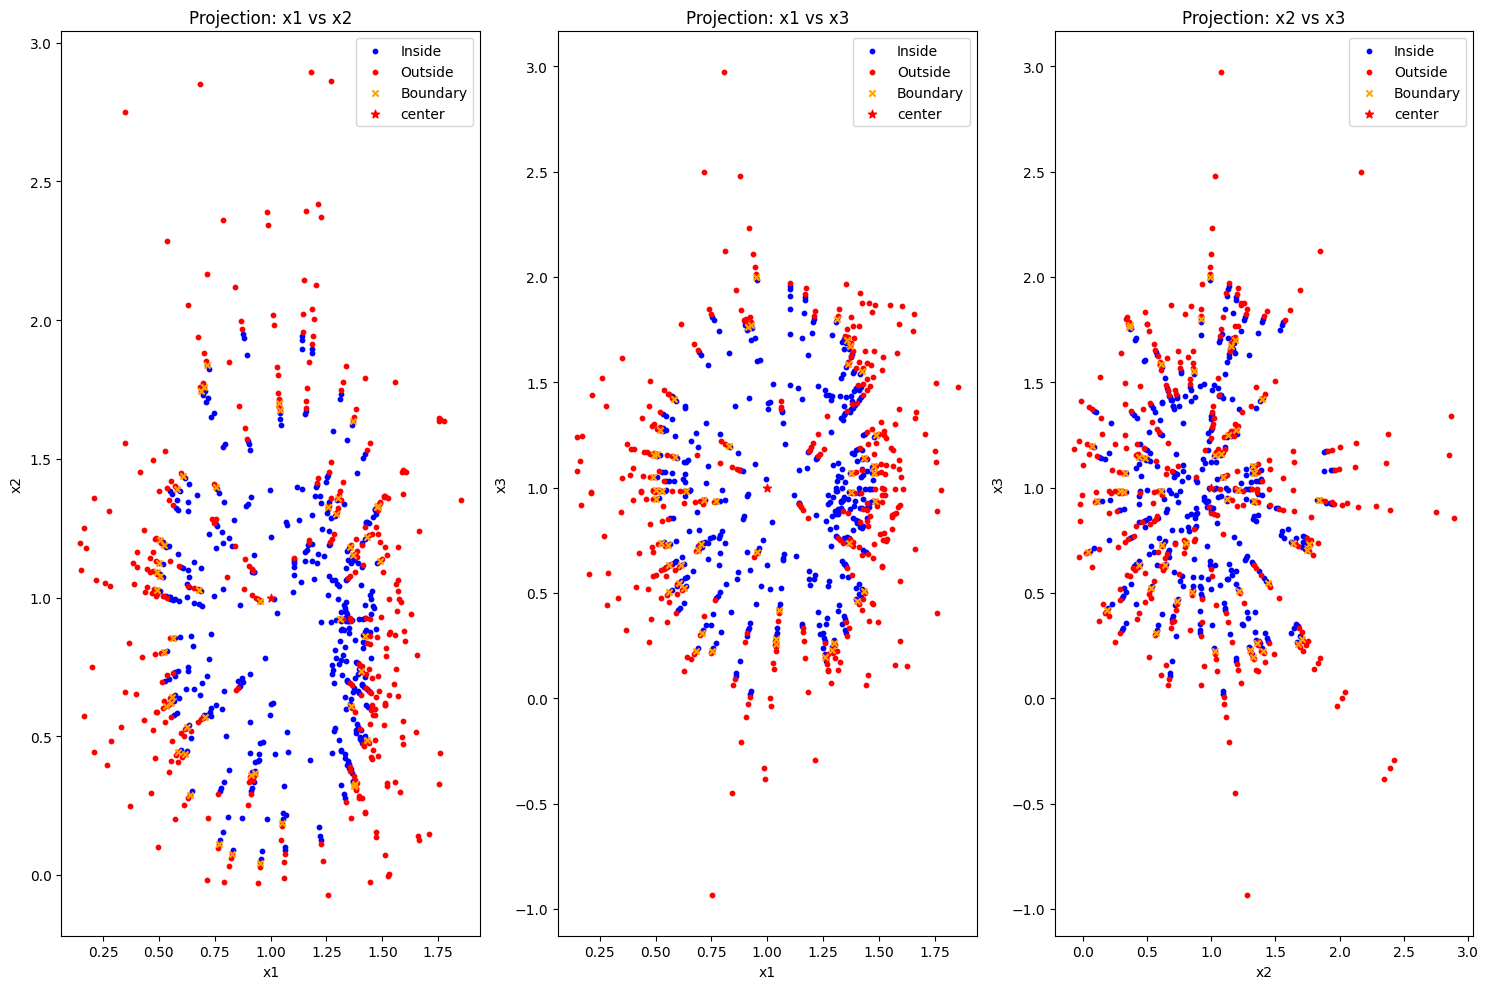

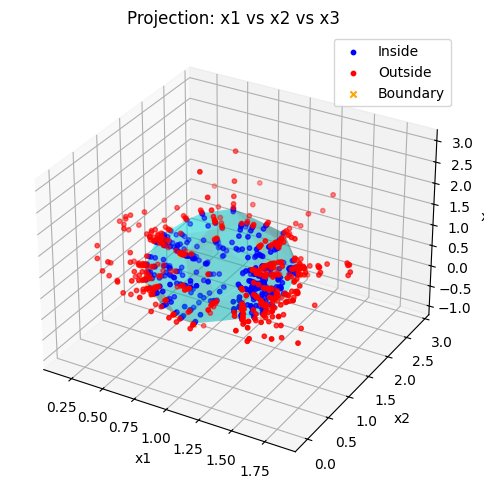

number of points tested: (772, 3)


In [23]:
def get_random_direction(ndim):
    """
    Generate a random unit vector (direction) in n-dimensional space.
    
    Returns:
    - np.array: A unit direction vector in n-dimensional space.
    """
    # Generate random points in n dimensions from a normal distribution
    direction = np.random.randn(ndim)
    
    # Normalize the vector to unit length
    return direction / np.linalg.norm(direction)
class RadialGrid:
    def __init__(self, center, max_radius, boundary_tolerance=0.1, angular_resolution=60, k=4, refinement_factor=3, is_point_in_region_func=None, dimensions=2):
        self.center = np.array(center)
        self.max_radius = max_radius
        self.angular_resolution = angular_resolution
        self.refinement_factor = refinement_factor
        self.is_point_in_region_func = is_point_in_region_func
        self.k = k
        self.boundary_tolerance = boundary_tolerance
        self.dimensions = dimensions

    def generate_grid(self):
        # Adjusting for higher dimensions
        all_points_tested = []
        all_points_inside = []
        all_points_outside = []
        boundary_points = []
        
        directions = generate_unit_vectors2(self.angular_resolution, self.dimensions)
        # Iterate over angular directions in higher dimensions
        for direction in directions:
            radius = self.k

            last_inside_point = None
            inner_radius = radius
            first_outside_point = None
            outer_radius = None
            found_boundary = False

            while radius < self.max_radius:
                point = self.center + direction * radius
                all_points_tested.append(point)
                inside = self.is_point_in_region_func(point)

                if inside:
                    all_points_inside.append(point)
                    last_inside_point = point
                    inner_radius = max(inner_radius, radius)
                    if first_outside_point is None:
                        radius *= 2  # Double step if no outside bound yet
                    else:
                        radius = (outer_radius + inner_radius) / 2  # Binary search-like approach
                else:
                    all_points_outside.append(point)
                    first_outside_point = point
                    if outer_radius is None:
                            outer_radius = radius
                    outer_radius = min(outer_radius, radius)
                    if last_inside_point is None:
                        radius /= 2  # Halve step if overshoot
                    else:
                        radius = (outer_radius + inner_radius) / 2  # Refined step

                # Perform boundary refinement when inner and outer radius are close enough
                if last_inside_point is not None and first_outside_point is not None and np.abs(outer_radius - inner_radius) < self.boundary_tolerance:
                    for i in range(1, self.refinement_factor + 1):
                        t = i / (self.refinement_factor + 1)
                        interp_point = (1 - t) * last_inside_point + t * first_outside_point
                        all_points_tested.append(interp_point)
                        if self.is_point_in_region_func(interp_point):
                            all_points_inside.append(interp_point)
                        else:
                            all_points_outside.append(interp_point)
                            boundary_points.append(interp_point)
                    break

        return np.array(all_points_tested), np.array(all_points_inside), np.array(all_points_outside), np.array(boundary_points)
    


def plot_radial_grid_3d(points_inside, points_outside, boundary_points, center, is_inside_region_func, max_radius, n_dims, convex_hull=None):
    """
    Function to plot the radial grid for n-dimensional data in 3D projections.
    
    Parameters:
    points_inside (numpy array): Points inside the region.
    points_outside (numpy array): Points outside the region.
    boundary_points (numpy array): Points on the boundary.
    center (numpy array): The center of the region (in n-dimensional space).
    is_inside_region_func (function): Function to check if a point is inside the region.
    max_radius (float): Maximum radius for the grid.
    n_dims (int): The number of dimensions for the grid.
    convex_hull (ConvexHull object): Convex hull object (optional).
    """
    # Generate all combinations of dimensions for plotting
    dim_combinations = list(combinations(range(n_dims), 3))
    
    # Calculate how many subplots are needed
    num_combinations = len(dim_combinations)
    rows = num_combinations // 2 + (num_combinations % 2 > 0)
    
    # Create a new figure with subplots
    fig = plt.figure(figsize=(15, 5 * rows))
    
    # Loop through the combinations and create 3D scatter plots
    for idx, (dim1, dim2, dim3) in enumerate(dim_combinations):
        ax = fig.add_subplot(rows, 2, idx + 1, projection='3d')
        
        # Plot points inside the region
        if points_inside.size > 0:
            ax.scatter(points_inside[:, dim1], points_inside[:, dim2], points_inside[:, dim3], c='blue', label='Inside', s=10)

        # Plot points outside the region
        if points_outside.size > 0:
            ax.scatter(points_outside[:, dim1], points_outside[:, dim2], points_outside[:, dim3], c='red', label='Outside', s=10)

        # Plot boundary points
        if boundary_points.size > 0:
            ax.scatter(boundary_points[:, dim1], boundary_points[:, dim2], boundary_points[:, dim3], c='orange', label='Boundary', s=20, marker='x')

        # Plot the convex hull if it exists (ConvexHull object passed)
        if convex_hull is not None:
            try:
                # Check if convex_hull is already a ConvexHull object
                if isinstance(convex_hull, ConvexHull):
                    hull = convex_hull
                else:
                    hull = ConvexHull(convex_hull)  # Create a hull if convex_hull is not a ConvexHull object
                    
                # Plot the convex hull using the simplices (faces) of the hull
                for simplex in hull.simplices:
                    ax.plot_trisurf(hull.points[simplex, 0], hull.points[simplex, 1], hull.points[simplex, 2], 
                                    color='cyan', alpha=0.3)
            except Exception as e:
                print(f"Error plotting convex hull: {e}")

        ax.set_xlabel(f'x{dim1+1}')
        ax.set_ylabel(f'x{dim2+1}')
        ax.set_zlabel(f'x{dim3+1}')
        ax.set_title(f'Projection: x{dim1+1} vs x{dim2+1} vs x{dim3+1}')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()
# Example usage
n_dims=3
actual_center = np.array([1, 1, 1])
ellipsoid_radii = np.array([0.5, 1, 1])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1
def compute_angular_resolution(dimensions, base=60, growth=2):
    # angular resolution = base * (growth)^{dimension -2}, ie. 60 directions for 2d
    return int(base * (growth ** (dimensions - 2)))
angular_resolution = compute_angular_resolution(dimensions=n_dims)
print(f"For n_dim = {n_dim}, angular_resolution = {angular_resolution}")
grid_gen = RadialGrid(
    center=[1.1, 0.9, 1],
    max_radius=100,
    boundary_tolerance=0.05,
    angular_resolution=angular_resolution,
    refinement_factor=1,
    k=0.5,
    is_point_in_region_func=is_inside_region,
    dimensions=n_dims
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()
# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# Optionally, expand the convex hull slightly
expanded_hull_points = points_inside[hull.vertices]
# expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)

# Plot the radial grid with boundary, inside, and outside points
plot_radial_grid(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, n_dims=n_dims)

# Plot tested points
plot_radial_grid_3d(points_inside, points_outside, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=hull, n_dims=n_dims)

print(f"number of points tested: {points_tested.shape}")

6d test

In [24]:
# Example usage
n_dims=6
actual_center = np.zeros(n_dim)
ellipsoid_radii = np.array([0.5, 1, 0.5, 1, 1, 0.6])

def is_inside_region(point):
    normalized = (point - actual_center) / ellipsoid_radii
    return np.linalg.norm(normalized) <= 1
def compute_angular_resolution(dimensions, base=60, growth=2):
    # angular resolution = base * (growth)^{dimension -2}, ie. 60 directions for 2d
    return int(base * (growth ** (dimensions - 2)))
angular_resolution = compute_angular_resolution(dimensions=n_dims)
print(f"For n_dim = {n_dim}, angular_resolution = {angular_resolution}")
grid_gen = RadialGrid(
    center=actual_center + 0.01*np.random.randn(n_dims),
    max_radius=100,
    boundary_tolerance=0.08,
    angular_resolution=angular_resolution,
    refinement_factor=1,
    k=0.5,
    is_point_in_region_func=is_inside_region,
    dimensions=n_dims
)

points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()
# Fit a convex hull around inside points
hull = ConvexHull(points_inside)

# # Optionally, expand the convex hull slightly
# expanded_hull_points = points_inside[hull.vertices]
# # expanded_hull_points = expand_convex_hull(points_inside[hull.vertices], expansion_factor=0.01)
# print(f"num_points tested : {points_tested.shape[0]}")
# # Plot the radial grid with boundary, inside, and outside points
# plot_radial_grid(points_inside, None, boundary_points, center=actual_center, is_inside_region_func=is_inside_region, max_radius=ellipsoid_radii, convex_hull=hull, n_dims=n_dims)


For n_dim = 6, angular_resolution = 960


In [25]:
from cupyx.profiler import benchmark

def f():
    points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()
    # Fit a convex hull around inside points
    hull = ConvexHull(points_inside)


def f2():
    points_tested, points_inside, points_outside, boundary_points = grid_gen.generate_grid()

print(benchmark(f, n_repeat=10))
print(benchmark(f2, n_repeat=10))

f                   :    CPU: 1902119.170 us   +/- 158214.339 (min: 1726040.100 / max: 2275517.900) us     GPU-0: 1902650.745 us   +/- 158211.542 (min: 1726604.370 / max: 2275939.209) us
f2                  :    CPU: 95536.590 us   +/- 44984.045 (min: 68680.200 / max: 220880.600) us     GPU-0: 96427.467 us   +/- 44979.545 (min: 69607.330 / max: 221644.775) us


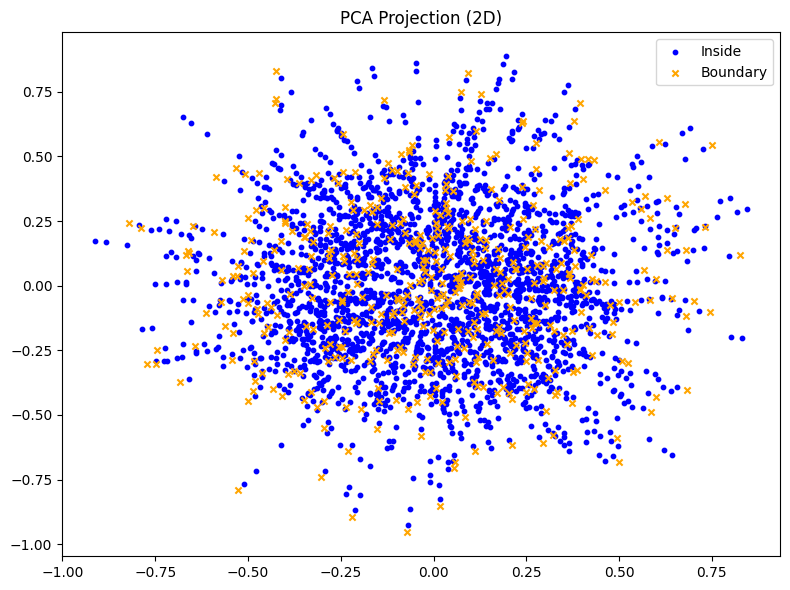

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_radial_grid_with_pca(points_inside, points_outside=None, boundary_points=None, dims=2):
    """
    Plots high-dimensional data using PCA (2D or 3D).
    Accepts any combination of points_inside, points_outside, and boundary_points.
    """
    # Default to empty arrays if not provided
    points_outside = points_outside if points_outside is not None else np.empty((0, points_inside.shape[1]))
    boundary_points = boundary_points if boundary_points is not None else np.empty((0, points_inside.shape[1]))

    # Combine for consistent PCA transformation
    all_points = np.concatenate([points_inside, points_outside, boundary_points], axis=0)
    pca = PCA(n_components=min(dims, all_points.shape[1]))
    pca_transformed = pca.fit_transform(all_points)

    # Split back into subsets
    split1 = len(points_inside)
    split2 = split1 + len(points_outside)
    inside_pca = pca_transformed[:split1]
    outside_pca = pca_transformed[split1:split2]
    boundary_pca = pca_transformed[split2:]

    fig = plt.figure(figsize=(8, 6))

    if dims == 3:
        ax = fig.add_subplot(111, projection='3d')
        if inside_pca.size > 0:
            ax.scatter(inside_pca[:, 0], inside_pca[:, 1], inside_pca[:, 2], c='blue', label='Inside', s=10)
        if outside_pca.size > 0:
            ax.scatter(outside_pca[:, 0], outside_pca[:, 1], outside_pca[:, 2], c='red', label='Outside', s=10)
        if boundary_pca.size > 0:
            ax.scatter(boundary_pca[:, 0], boundary_pca[:, 1], boundary_pca[:, 2], c='orange', label='Boundary', s=20, marker='x')
        ax.set_title("PCA Projection (3D)")
    else:
        ax = fig.add_subplot(111)
        if inside_pca.size > 0:
            ax.scatter(inside_pca[:, 0], inside_pca[:, 1], c='blue', label='Inside', s=10)
        if outside_pca.size > 0:
            ax.scatter(outside_pca[:, 0], outside_pca[:, 1], c='red', label='Outside', s=10)
        if boundary_pca.size > 0:
            ax.scatter(boundary_pca[:, 0], boundary_pca[:, 1], c='orange', label='Boundary', s=20, marker='x')
        ax.set_title("PCA Projection (2D)")

    ax.legend()
    plt.tight_layout()
    plt.show()
plot_radial_grid_with_pca(points_inside,None,  boundary_points, dims=n_dim)
